In [768]:
import pandas as pd
import numpy as np 
import pickle
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [719]:
df = pd.read_csv("matches/noyes_actual_matches_arrival_new.csv")

In [720]:
df["hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
df["dayofweek"] = pd.to_datetime(df["scheduled_arr"]).dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)


In [721]:
df = pd.get_dummies(df, columns=["direction"], drop_first=True)

In [722]:
base_features = ["hour", "dayofweek", "is_weekend", "direction_Linden"]
X = df[base_features]
y = df["error_min"]


In [723]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(base_features)


In [724]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [725]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [726]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE with polynomial features:", mse)


Test MSE with polynomial features: 6.208235863425329


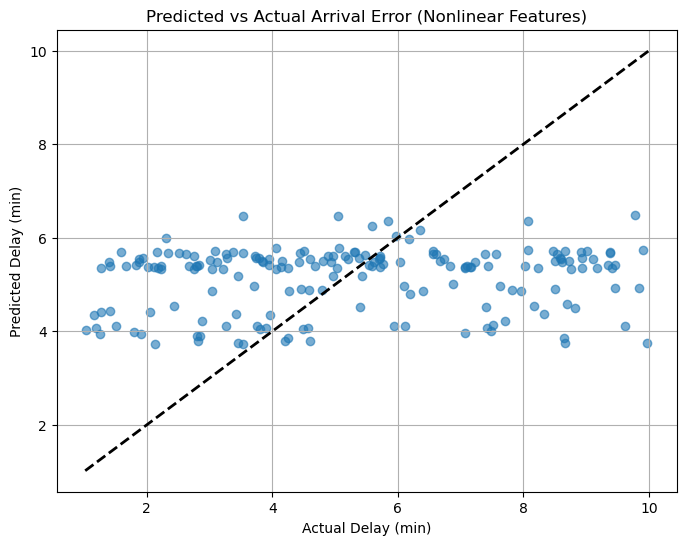

In [727]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Predicted vs Actual Arrival Error (Nonlinear Features)")
plt.grid(True)
plt.show()

In [728]:
coeff_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": model.coef_
}).sort_values("coefficient", key=abs, ascending=False)

coeff_df.head(10)  # Top 10 influential features


,feature,coefficient
11,is_weekend^2,-2.054508
2,is_weekend,-2.054508
9,dayofweek is_weekend,0.948033
13,direction_Linden^2,0.884868
3,direction_Linden,0.884868
12,is_weekend direction_Linden,0.223921
1,dayofweek,0.163994
10,dayofweek direction_Linden,-0.130410
6,hour is_weekend,-0.095045
8,dayofweek^2,-0.054210


In [729]:
# Cleanup poly features
# Remove redundant features
# e.g. is_weekend^2 if is_weekend is binary anyway (0 or 1)
# Remove very small coefficient terms (< 0.05 in magnitude)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
drop_cols = [
    "is_weekend^2",
    "direction_Linden^2",
    "is_weekend direction_Linden"
]
X_poly_df_clean = X_poly_df.drop(columns=drop_cols)

In [730]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_df_clean, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression MSE:", mse_lin)

Linear Regression MSE: 6.215643545209592


In [731]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression MSE:", mse_ridge)
print("Best alpha:", ridge_model.alpha_)

Ridge Regression MSE: 6.187573426263646
Best alpha: 1.0


In [732]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression MSE:", mse_lasso)
print("Best alpha:", lasso_model.alpha_)

Lasso Regression MSE: 6.153151696630566
Best alpha: 0.01


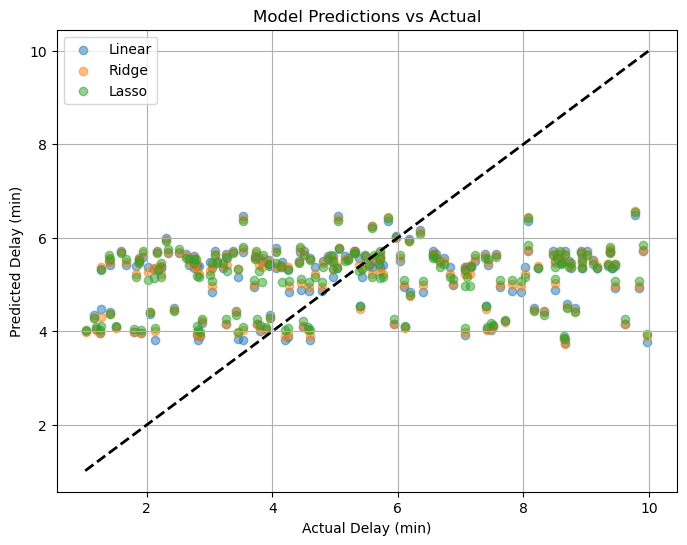

In [733]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear")
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label="Ridge")
plt.scatter(y_test, y_pred_lasso, alpha=0.5, label="Lasso")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [734]:
def show_coefficients(model, label):
    coef_df = pd.DataFrame({
        "feature": X_poly_df_clean.columns,
        "coefficient": model.coef_
    }).sort_values("coefficient", key=abs, ascending=False)
    print(f"\nTop coefficients for {label}:")
    display(coef_df.head(10))

show_coefficients(lin_model, "Linear Regression")
show_coefficients(ridge_model, "Ridge Regression")
show_coefficients(lasso_model, "Lasso Regression")


Top coefficients for Linear Regression:


,feature,coefficient
2,is_weekend,-3.926868
3,direction_Linden,1.713565
9,dayofweek is_weekend,0.939334
1,dayofweek,0.152912
10,dayofweek direction_Linden,-0.099462
6,hour is_weekend,-0.092192
8,dayofweek^2,-0.054442
0,hour,-0.021186
7,hour direction_Linden,-0.021015
5,hour dayofweek,0.015282



Top coefficients for Ridge Regression:


,feature,coefficient
3,direction_Linden,1.571747
2,is_weekend,-1.364561
9,dayofweek is_weekend,0.454302
6,hour is_weekend,-0.110027
10,dayofweek direction_Linden,-0.092438
8,dayofweek^2,-0.027689
0,hour,-0.023064
1,dayofweek,0.022217
5,hour dayofweek,0.016966
7,hour direction_Linden,-0.010992



Top coefficients for Lasso Regression:


,feature,coefficient
3,direction_Linden,1.146997
9,dayofweek is_weekend,0.139865
6,hour is_weekend,-0.098238
10,dayofweek direction_Linden,-0.033148
8,dayofweek^2,-0.012076
5,hour dayofweek,0.010940
7,hour direction_Linden,0.009970
0,hour,-0.007961
4,hour^2,0.001588
1,dayofweek,-0.000000


In [735]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest MSE: 6.2231794664597615


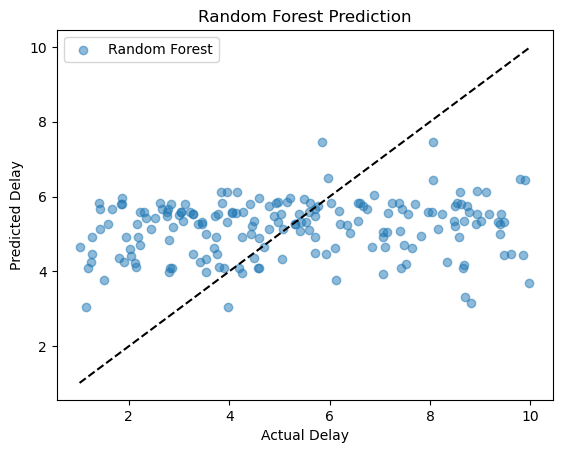

In [736]:
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Random Forest Prediction")
plt.legend()
plt.show()


In [737]:
df["actual_arr"] = pd.to_datetime(df["actual_arr"])
df["first_seen"] = pd.to_datetime(df["first_seen"])

df["minutes_seen_before"] = (df["actual_arr"] - df["first_seen"]).dt.total_seconds() / 60.0
df["was_approaching"] = (df["minutes_seen_before"] < 2).astype(int)  # or use raw value
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)


Random Forest MSE with new features: 5.02464980859275


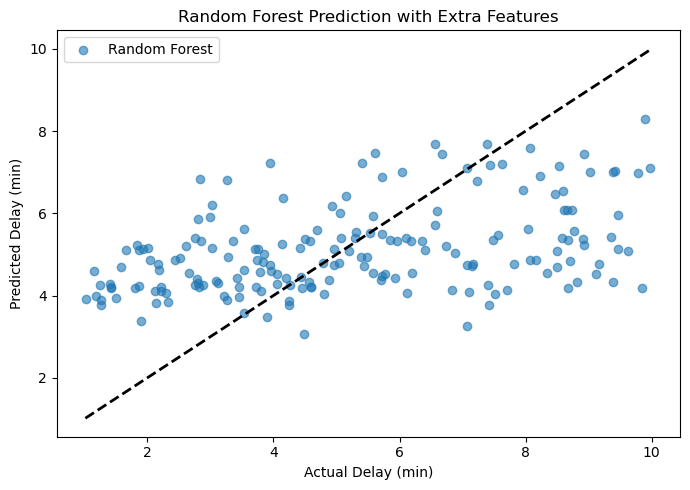

In [738]:
features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before", "was_approaching", "hour_sin", "hour_cos"
]

X = df[features]
y = df["error_min"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Random Forest MSE with new features:", mse)

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, label="Random Forest")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Random Forest Prediction with Extra Features")
plt.legend()
plt.tight_layout()
plt.show()

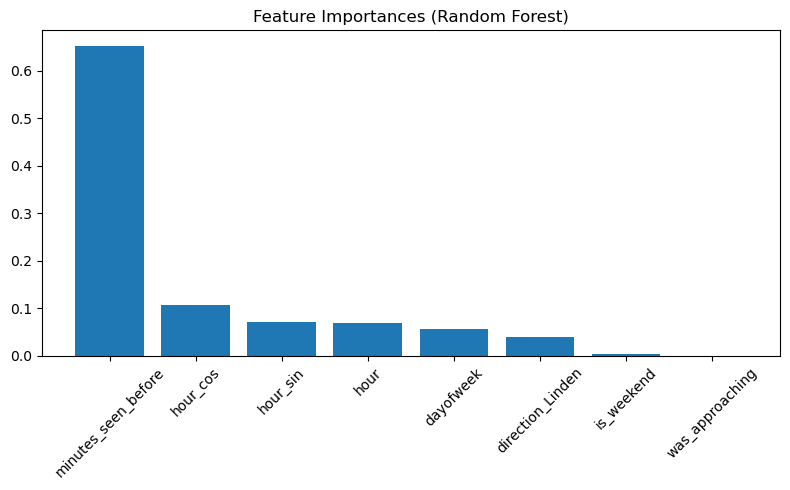

In [739]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), X.columns[sorted_idx], rotation=45)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [740]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [741]:
# Predict and calculate MSE
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


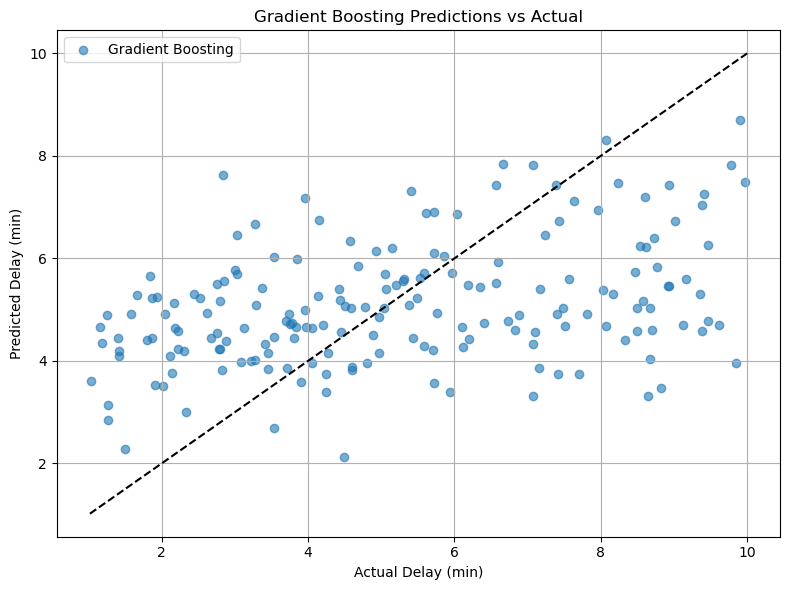

In [742]:
# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Gradient Boosting")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Gradient Boosting Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

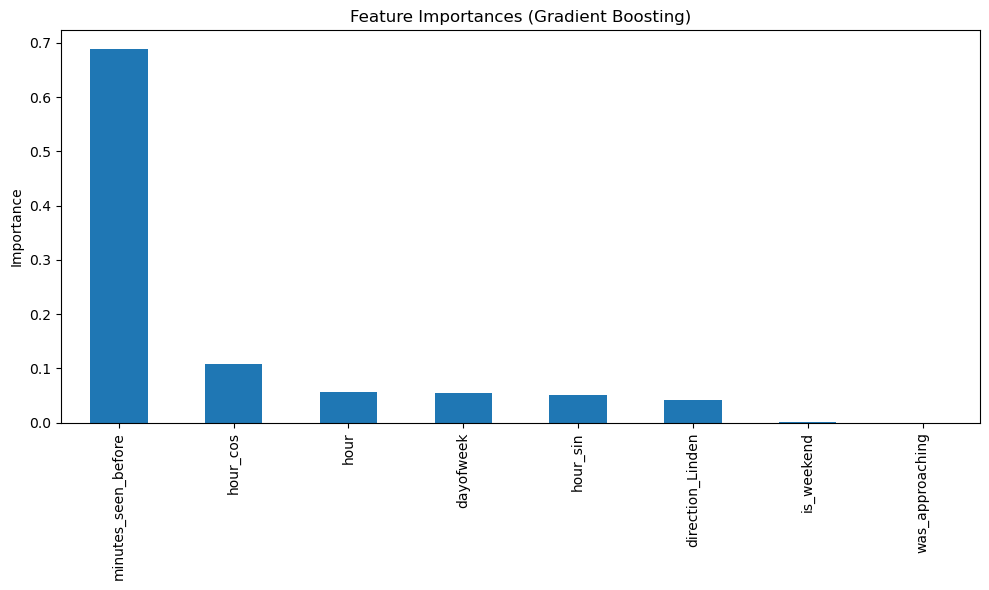

In [743]:
# Feature importances
importances = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind="bar")
plt.title("Feature Importances (Gradient Boosting)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [744]:
# Combine all models for final predictions
df = pd.read_csv("matches/noyes_actual_matches_arrival_new.csv")


In [745]:
import ast

df["hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
df["dayofweek"] = pd.to_datetime(df["scheduled_arr"]).dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["minutes_seen_before"] = (pd.to_datetime(df["actual_arr"]) - pd.to_datetime(df["first_seen"])).dt.total_seconds() / 60.0
df["was_approaching"] = (df["minutes_seen_before"] < 2).astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["direction_Linden"] = (df["direction"] == "Linden").astype(int)

# describe the df
df["opp_arrivals"] = df["opp_dir_live_arrivals"].apply(ast.literal_eval)
df["opp_count"] = df["opp_arrivals"].apply(len)
df["opp_min"] = df["opp_arrivals"].apply(lambda x: min(x) if x else -1)
df["opp_mean"] = df["opp_arrivals"].apply(lambda x: sum(x) / len(x) if x else -1)
df["opp_std"] = df["opp_arrivals"].apply(lambda x: np.std(x) if x else -1)

# Optional: fill NaNs for rows without opposite trains
df.fillna({"opp_min": -1, "opp_mean": -1, "opp_std": -1}, inplace=True)


features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before", "was_approaching",
    "hour_sin", "hour_cos",
    "opp_count", "opp_min", "opp_mean", "opp_std"
]
X = df[features]
y = df["error_min"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [746]:
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5),
    "Lasso": LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {"model": model, "pred": y_pred, "mse": mse}



In [747]:
# For tree-based models
rf = models["RandomForest"]
gb = models["GradientBoost"]
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances_gb = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nRandom Forest Feature Importances:\n", importances_rf)
print("\nGradient Boosting Feature Importances:\n", importances_gb)



Random Forest Feature Importances:
 minutes_seen_before    0.472690
dayofweek              0.097209
opp_min                0.082878
hour_cos               0.074546
opp_mean               0.070104
hour_sin               0.064656
hour                   0.062789
opp_std                0.031331
direction_Linden       0.018409
opp_count              0.018236
is_weekend             0.007152
was_approaching        0.000000
dtype: float64

Gradient Boosting Feature Importances:
 minutes_seen_before    0.532387
opp_mean               0.080751
hour_cos               0.080454
opp_min                0.079201
hour                   0.055294
dayofweek              0.047119
opp_std                0.046369
hour_sin               0.036119
direction_Linden       0.032563
opp_count              0.008786
is_weekend             0.000955
was_approaching        0.000000
dtype: float64


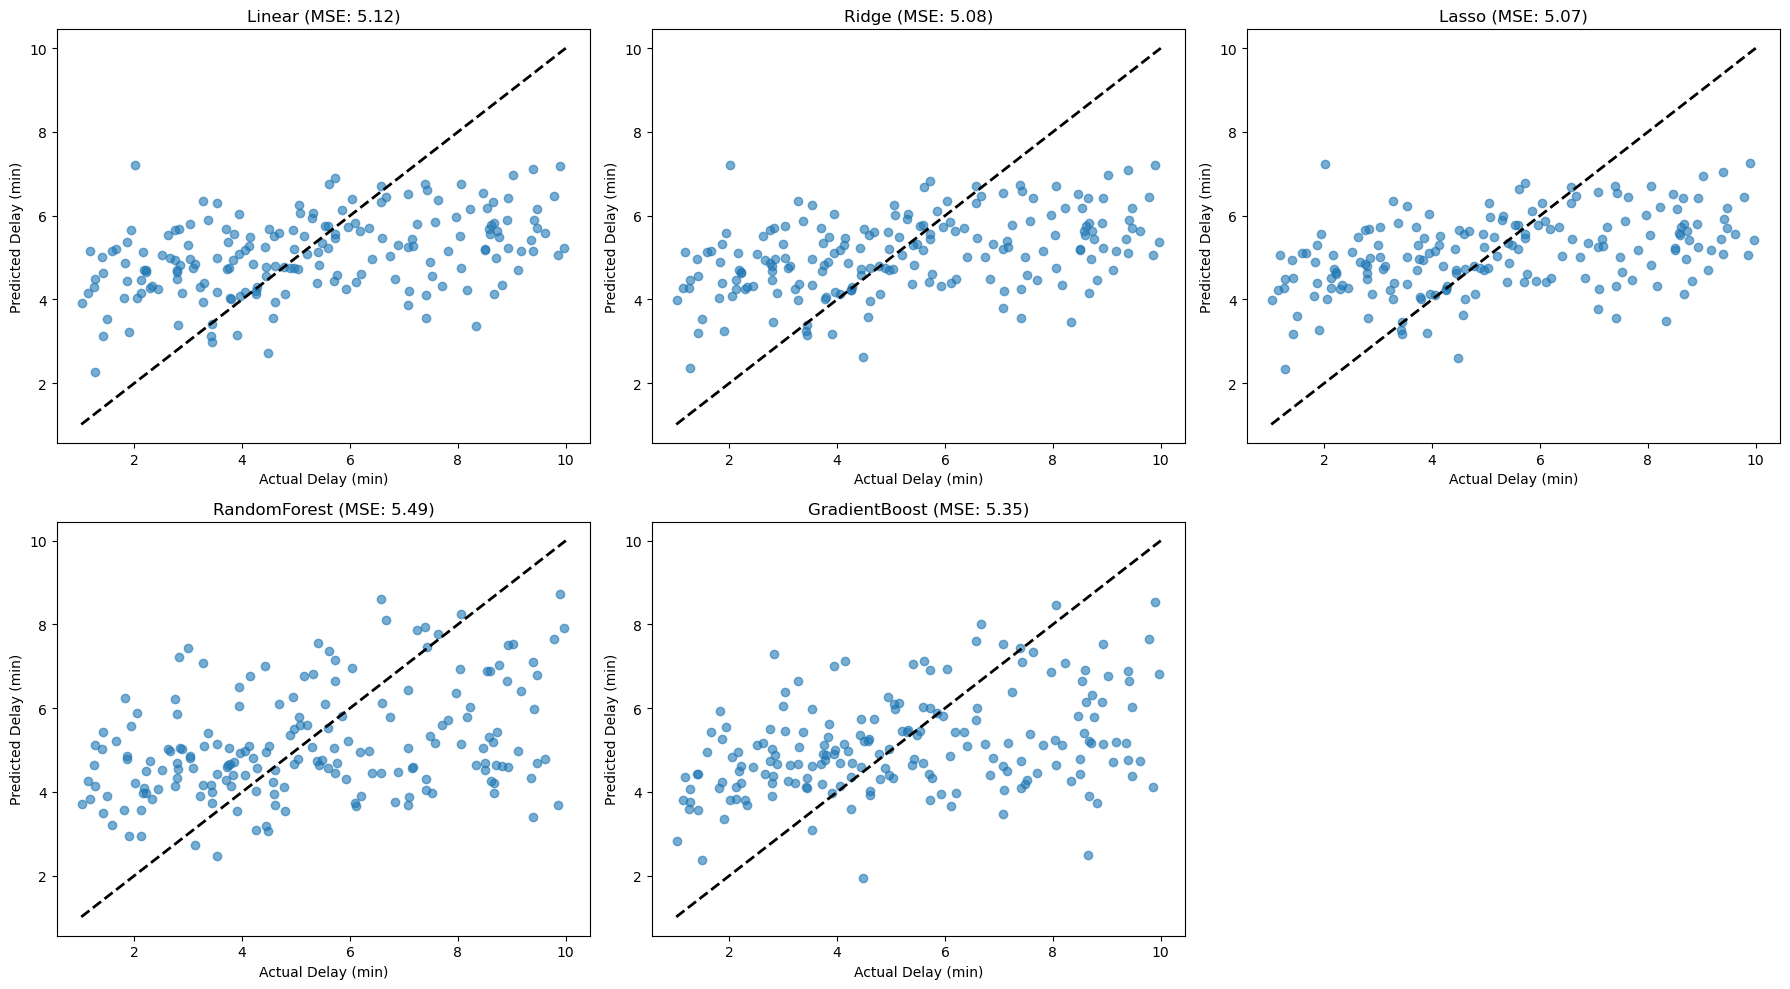

In [748]:
# Plot predicted vs actual for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    ax.scatter(y_test, result["pred"], alpha=0.6)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_title(f"{name} (MSE: {result['mse']:.2f})")
    ax.set_xlabel("Actual Delay (min)")
    ax.set_ylabel("Predicted Delay (min)")

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [749]:
df["opp_min_times_hour"] = df["opp_min"] * df["hour"]
df["opp_mean_diff"] = df["opp_mean"] - df["minutes_seen_before"]

df["delta_opp_min"] = df["opp_min"].diff().fillna(0)

In [750]:
df["opp_count_bin"] = pd.cut(df["opp_count"], bins=[-1, 0, 2, 5, 20], labels=["0", "1-2", "3-5", "6+"])
df = pd.get_dummies(df, columns=["opp_count_bin"], drop_first=True)


In [751]:
def asymmetric_obj(preds, dtrain):
    """
    XGBoost custom objective that penalizes over-prediction more heavily.
    If residual = pred - true:
      • grad = 2*residual  when residual > 0  (over-prediction)
      • grad = residual     when residual <= 0 (under-prediction)
      • hess = 2.0          when residual > 0
      • hess = 1.0          when residual <= 0
    """
    labels   = dtrain.get_label()
    residual = preds - labels

    grad = np.where(residual > 0, 2 * residual, residual)
    hess = np.where(residual > 0, 2.0, 1.0)
    return grad, hess

In [840]:
def train(use_time_split=True, features=features, scale_linear_models=True):
    
    X = df[features]
    y = df["error_min"]

    if use_time_split:
        df_sorted = df.sort_values("scheduled_arr")
        cutoff = int(0.8 * len(df_sorted))
        train_df = df_sorted.iloc[:cutoff]
        test_df = df_sorted.iloc[cutoff:]
        X_train = train_df[features]
        y_train = train_df["error_min"]
        X_test = test_df[features]
        y_test = test_df["error_min"]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)


    if X.columns.duplicated().any():
        dupes = X.columns[X.columns.duplicated()].tolist()
        raise ValueError(f"Duplicate column names found: {dupes}")


    # Identify columns in X_train that are constant (nunique==1) or fully NaN
    constant_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
    na_cols       = [col for col in X_train.columns if X_train[col].isna().all()]

    drop_cols = list(set(constant_cols + na_cols))
    if len(drop_cols) > 0:
        X_train.drop(columns=drop_cols, inplace=True)
        X_test.drop(columns=drop_cols, inplace=True)
        features = [f for f in features if f not in drop_cols]
    print(drop_cols)

    ###########################
    # SCALE CONTINUOUS FEATURES FOR LINEAR MODELS
    ###########################
    continuous_cols = [
        "hour", "minutes_seen_before", "opp_min", "opp_mean", "opp_std",
        "opp_min_times_hour", "opp_mean_diff", "delta_opp_min",
        "prev_sched_gap", "next_sched_gap", "trains_next_30min",
        "prev_error_min", "error_diff_1_2"
    ]
    # Keep only those that still exist in features (after dropping constants)
    continuous_cols = [c for c in continuous_cols if c in X_train.columns]

    if scale_linear_models and continuous_cols:
        scaler = StandardScaler().fit(X_train[continuous_cols])
        X_train.loc[:, continuous_cols] = scaler.transform(X_train[continuous_cols])
        X_test.loc[:, continuous_cols] = scaler.transform(X_test[continuous_cols])

    # Initialize models
    models = {
        "Linear": LinearRegression(),
        "Ridge": RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5),
        "Lasso": LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5, max_iter=5000),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
        "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, min_child_samples=1, random_state=42)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"{name} MSE: {mse:.2f}")
        results[name] = {"model": model, "pred": y_pred, "mse": mse}

    # Feature importances (tree-based)
    tree_models = ["RandomForest", "GradientBoost", "XGBoost", "LightGBM"]
    for name in tree_models:
        model = results[name]["model"]
        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print(f"\n{name} Feature Importances:\n", importances.head(5))

    # Plot predicted vs actua
    num_models = len(results)
    cols = 3
    rows = math.ceil(num_models / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()
    
    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx]
        ax.scatter(y_test, result["pred"], alpha=0.6)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        ax.set_title(f"{name} (MSE: {result['mse']:.2f})")
        ax.set_xlabel("Actual Delay (min)")
        ax.set_ylabel("Predicted Delay (min)")
    
    # Remove any extra subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()



In [813]:
df["prev_error_min"] = df.groupby("direction_Linden")["error_min"].shift(1).fillna(0)

features = [
    "hour", "dayofweek", "is_weekend", "direction_Linden",
    "minutes_seen_before",
    "hour_sin", "hour_cos",
    "opp_count", "opp_min", "opp_mean", "opp_std",
    "opp_min_times_hour", "opp_mean_diff", "delta_opp_min",
    "prev_error_min"
]

[]
Linear MSE: 6.79
Ridge MSE: 6.76
Lasso MSE: 6.75
RandomForest MSE: 7.44
GradientBoost MSE: 7.33
XGBoost MSE: 8.67
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1400
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 15
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 8.14

RandomForest Feature Importances:
 opp_mean_diff          0.202526
minutes_seen_before    0.200884
prev_error_min         0.168713
delta_opp_min          0.078410
opp_min_times_hour     0.068409
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff          0.252206
minutes_seen_before    0.238101
prev_error_min         0.155256
delta_opp_min          0.071280
opp_min_times_hour     0.061096
dtype: float64

XGBoost Feature Importances:
 opp_mean_diff          0.133534
hour_sin               0.127555
opp_st

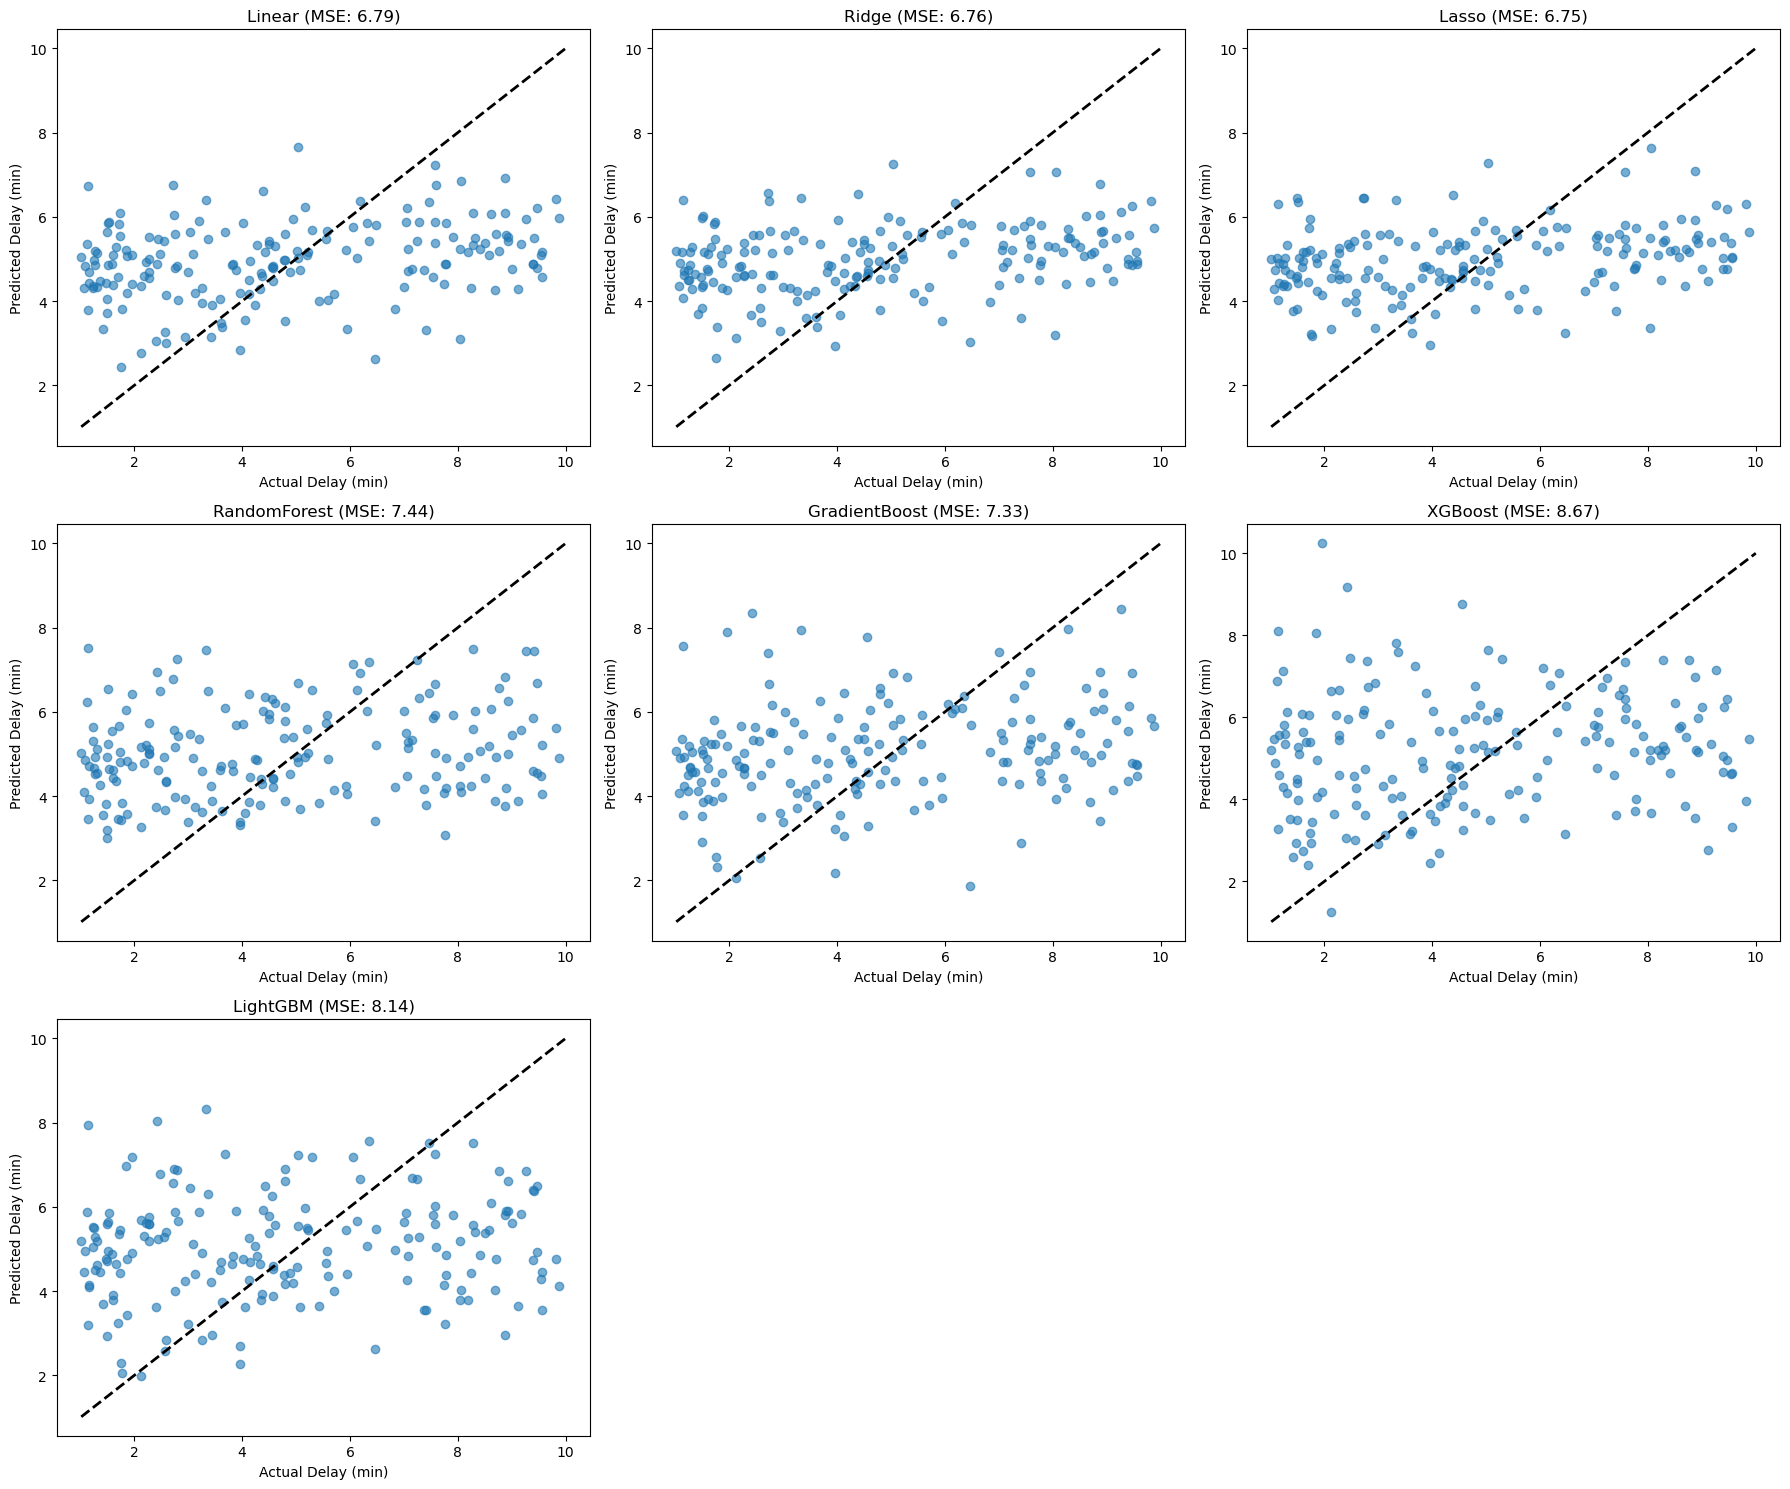

In [814]:
train(features=features, scale_linear_models=True)

[]
Linear MSE: 6.93
Ridge MSE: 6.89
Lasso MSE: 6.82
RandomForest MSE: 7.28
GradientBoost MSE: 7.42
XGBoost MSE: 7.88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 16
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 7.81

RandomForest Feature Importances:
 opp_mean_diff          0.187405
minutes_seen_before    0.181710
prev_error_min         0.142101
next_sched_gap         0.118073
delta_opp_min          0.069583
dtype: float64

GradientBoost Feature Importances:
 opp_mean_diff          0.233118
minutes_seen_before    0.199747
prev_error_min         0.123621
next_sched_gap         0.113688
delta_opp_min          0.074411
dtype: float64

XGBoost Feature Importances:
 opp_mean_diff          0.131478
hour_sin               0.116317
opp_st

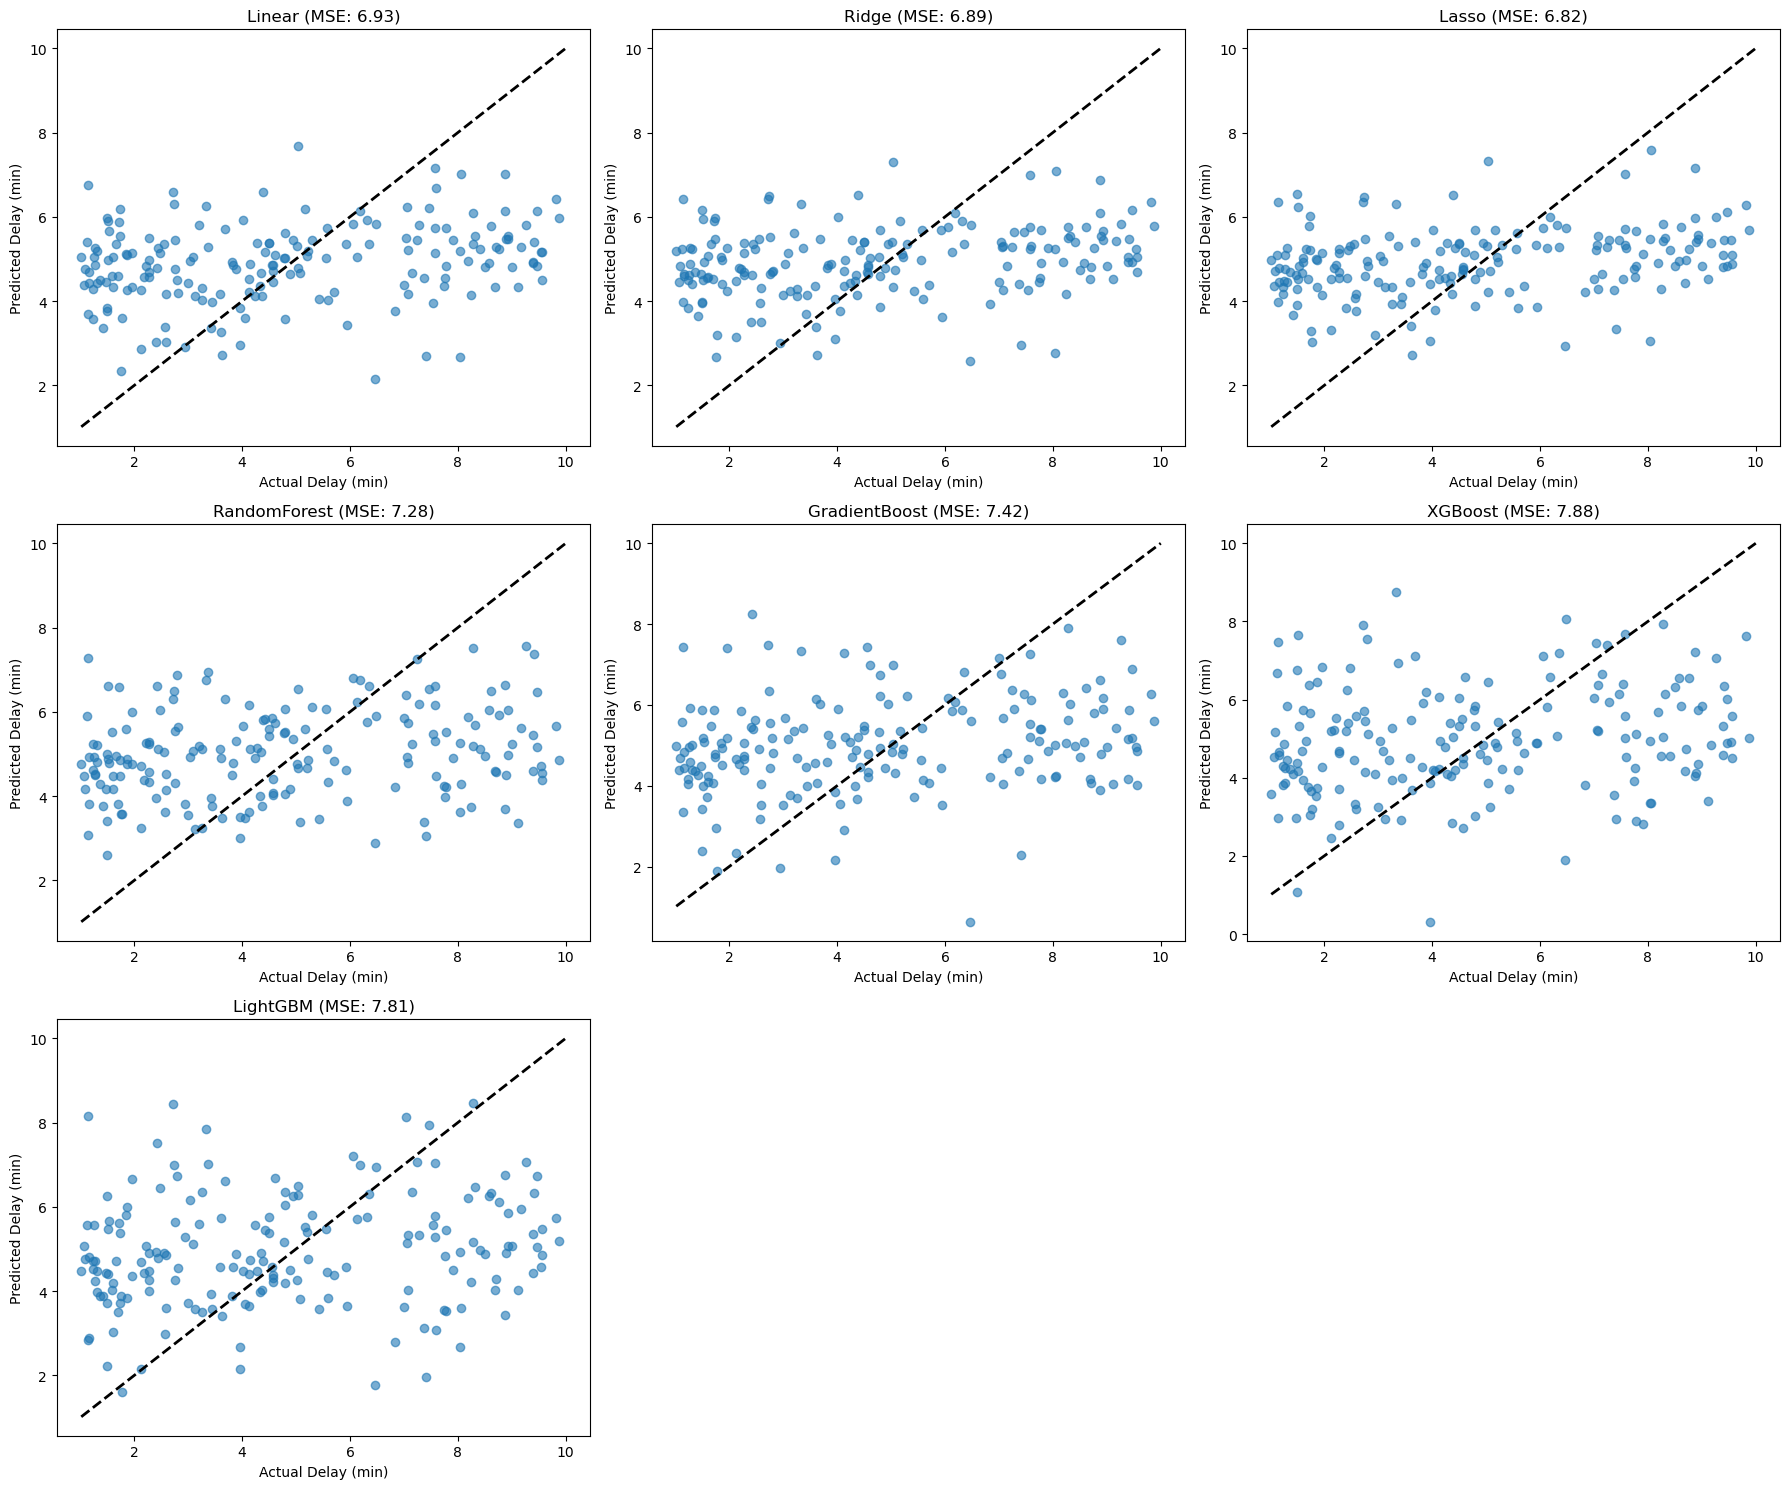

In [815]:
# the scheduled_arr is a string use it as a timestamp
df["scheduled_arr"] = pd.to_datetime(df["scheduled_arr"])
df["next_sched_gap"] = df.groupby("direction_Linden")["scheduled_arr"].shift(-1) - df["scheduled_arr"]
df["next_sched_gap"] = df["next_sched_gap"].dt.total_seconds() / 60.0
df["next_sched_gap"].fillna(0, inplace=True)
features.append("next_sched_gap")
train(features=features, scale_linear_models=True)

In [816]:
df["prev_error_times_seen"] = df["prev_error_min"] * df["minutes_seen_before"]

In [817]:
df["scheduled_hour"] = pd.to_datetime(df["scheduled_arr"]).dt.hour
rolling_avg = df.groupby("scheduled_hour")["error_min"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df["hourly_error_trend"] = rolling_avg

In [818]:
df["is_rush"] = ((df["hour"].between(7, 9)) | (df["hour"].between(16, 18))).astype(int)
df["weekday_rush"] = (df["is_rush"] & (df["dayofweek"] < 5)).astype(int)


In [819]:
features.append("prev_error_times_seen")
features.append("hourly_error_trend")
features.append("is_rush")
features.append("weekday_rush")

[]
Linear MSE: 4.77
Ridge MSE: 4.73
Lasso MSE: 4.68
RandomForest MSE: 5.05
GradientBoost MSE: 4.95
XGBoost MSE: 5.58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 20
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.22

RandomForest Feature Importances:
 hourly_error_trend       0.480832
minutes_seen_before      0.088028
next_sched_gap           0.068899
opp_mean_diff            0.060009
prev_error_times_seen    0.058773
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.605634
minutes_seen_before    0.106493
opp_mean_diff          0.053778
next_sched_gap         0.053336
prev_error_min         0.035345
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend       0.266797
weekday_rush             0

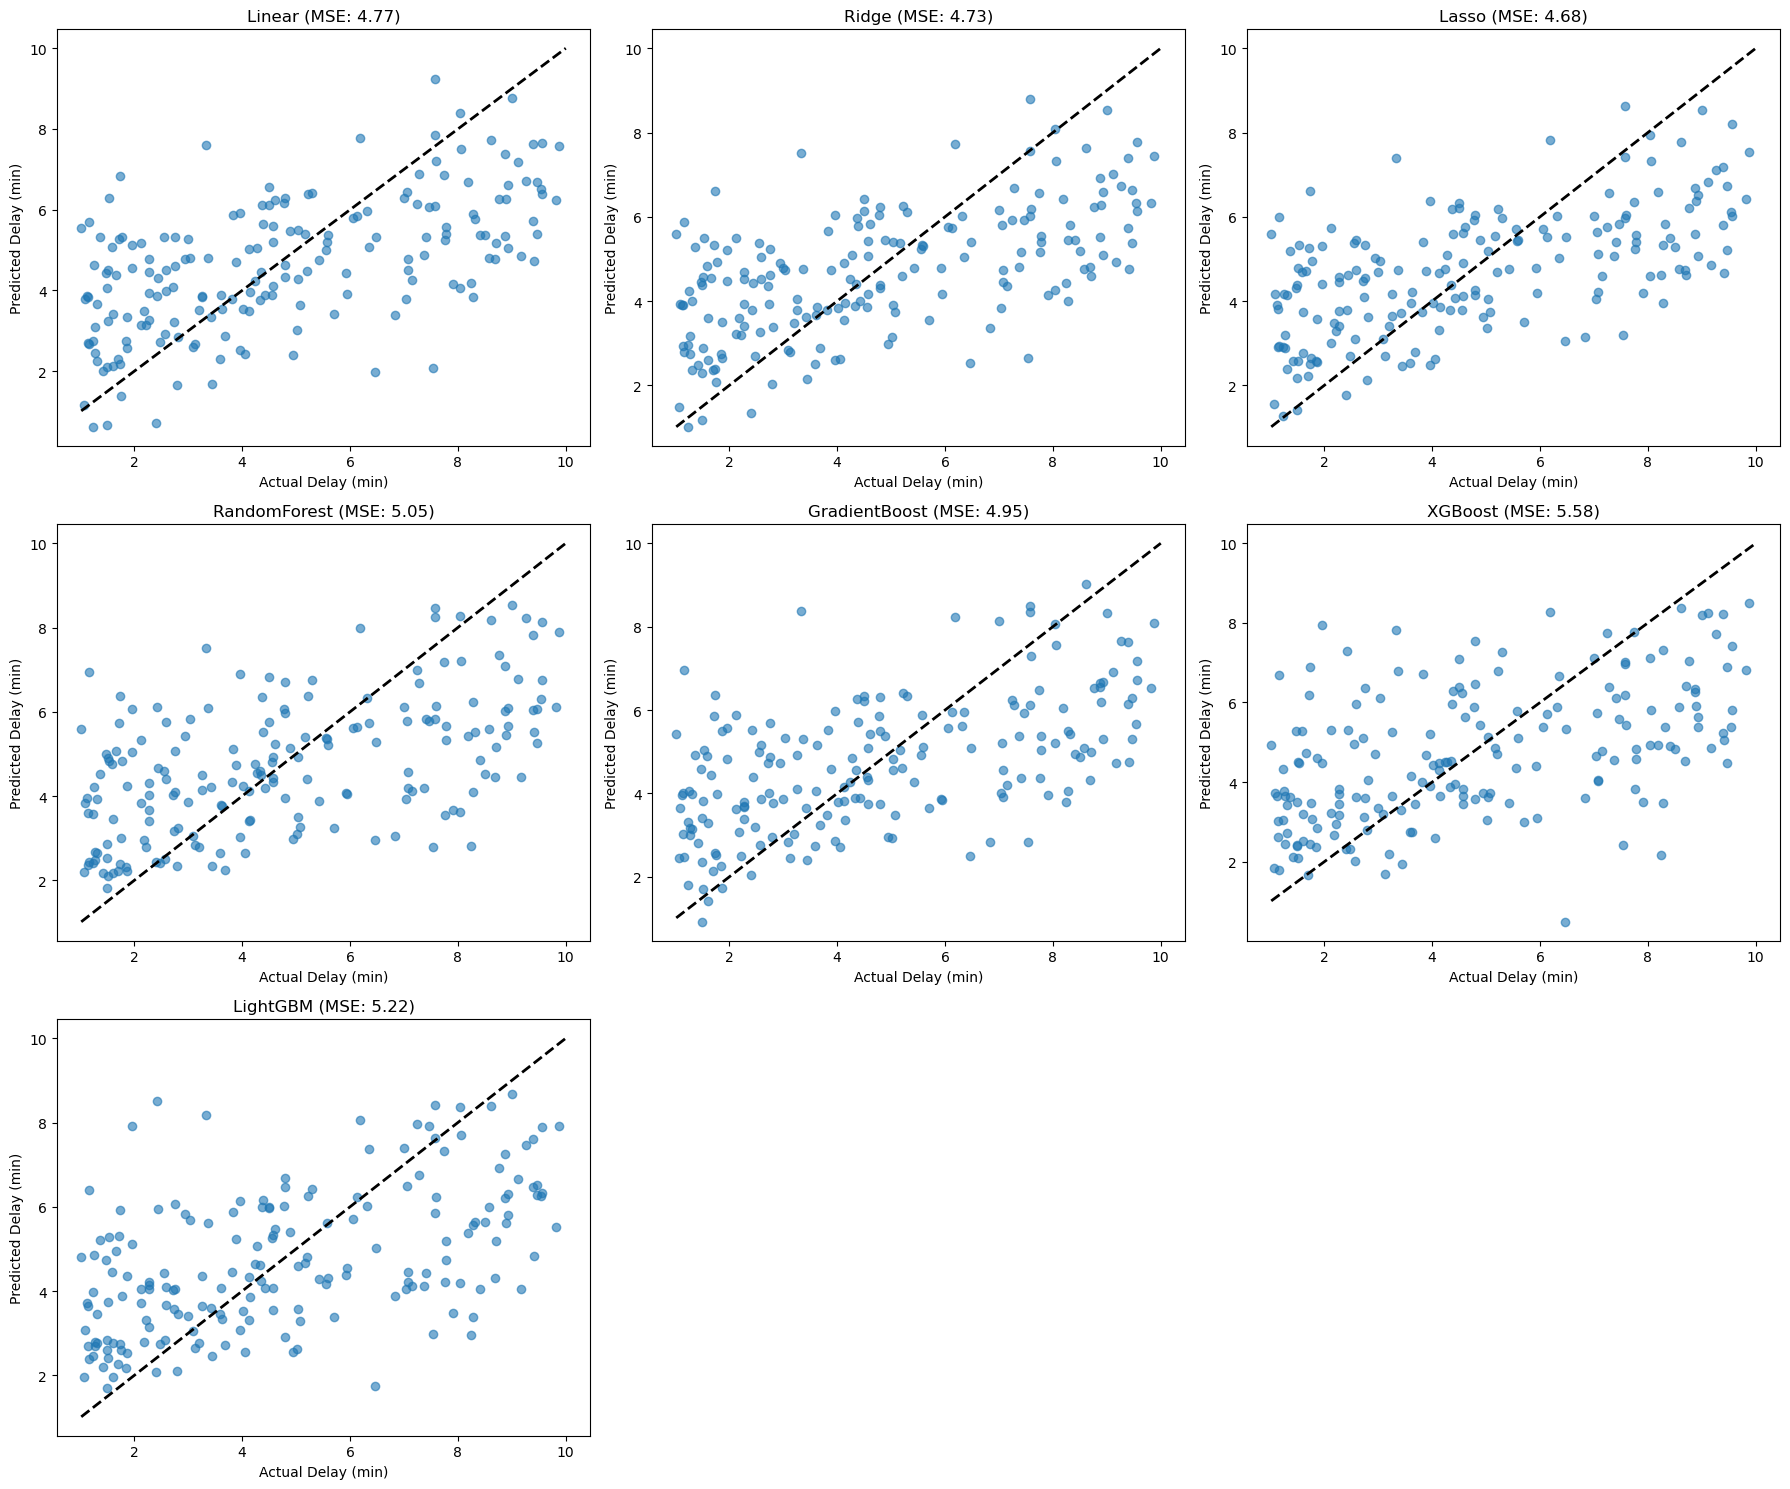

In [820]:
train(features=features, scale_linear_models=True)

[]
Linear MSE: 4.77
Ridge MSE: 4.72
Lasso MSE: 4.68
RandomForest MSE: 5.04
GradientBoost MSE: 5.21
XGBoost MSE: 5.67
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 21
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.16

RandomForest Feature Importances:
 hourly_error_trend     0.466603
hourly_error_std       0.147542
minutes_seen_before    0.075000
next_sched_gap         0.049935
opp_mean_diff          0.046593
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.576687
hourly_error_std       0.125527
minutes_seen_before    0.092587
opp_mean_diff          0.049432
next_sched_gap         0.034720
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.284784
weekday_rush           0.117771
hourly

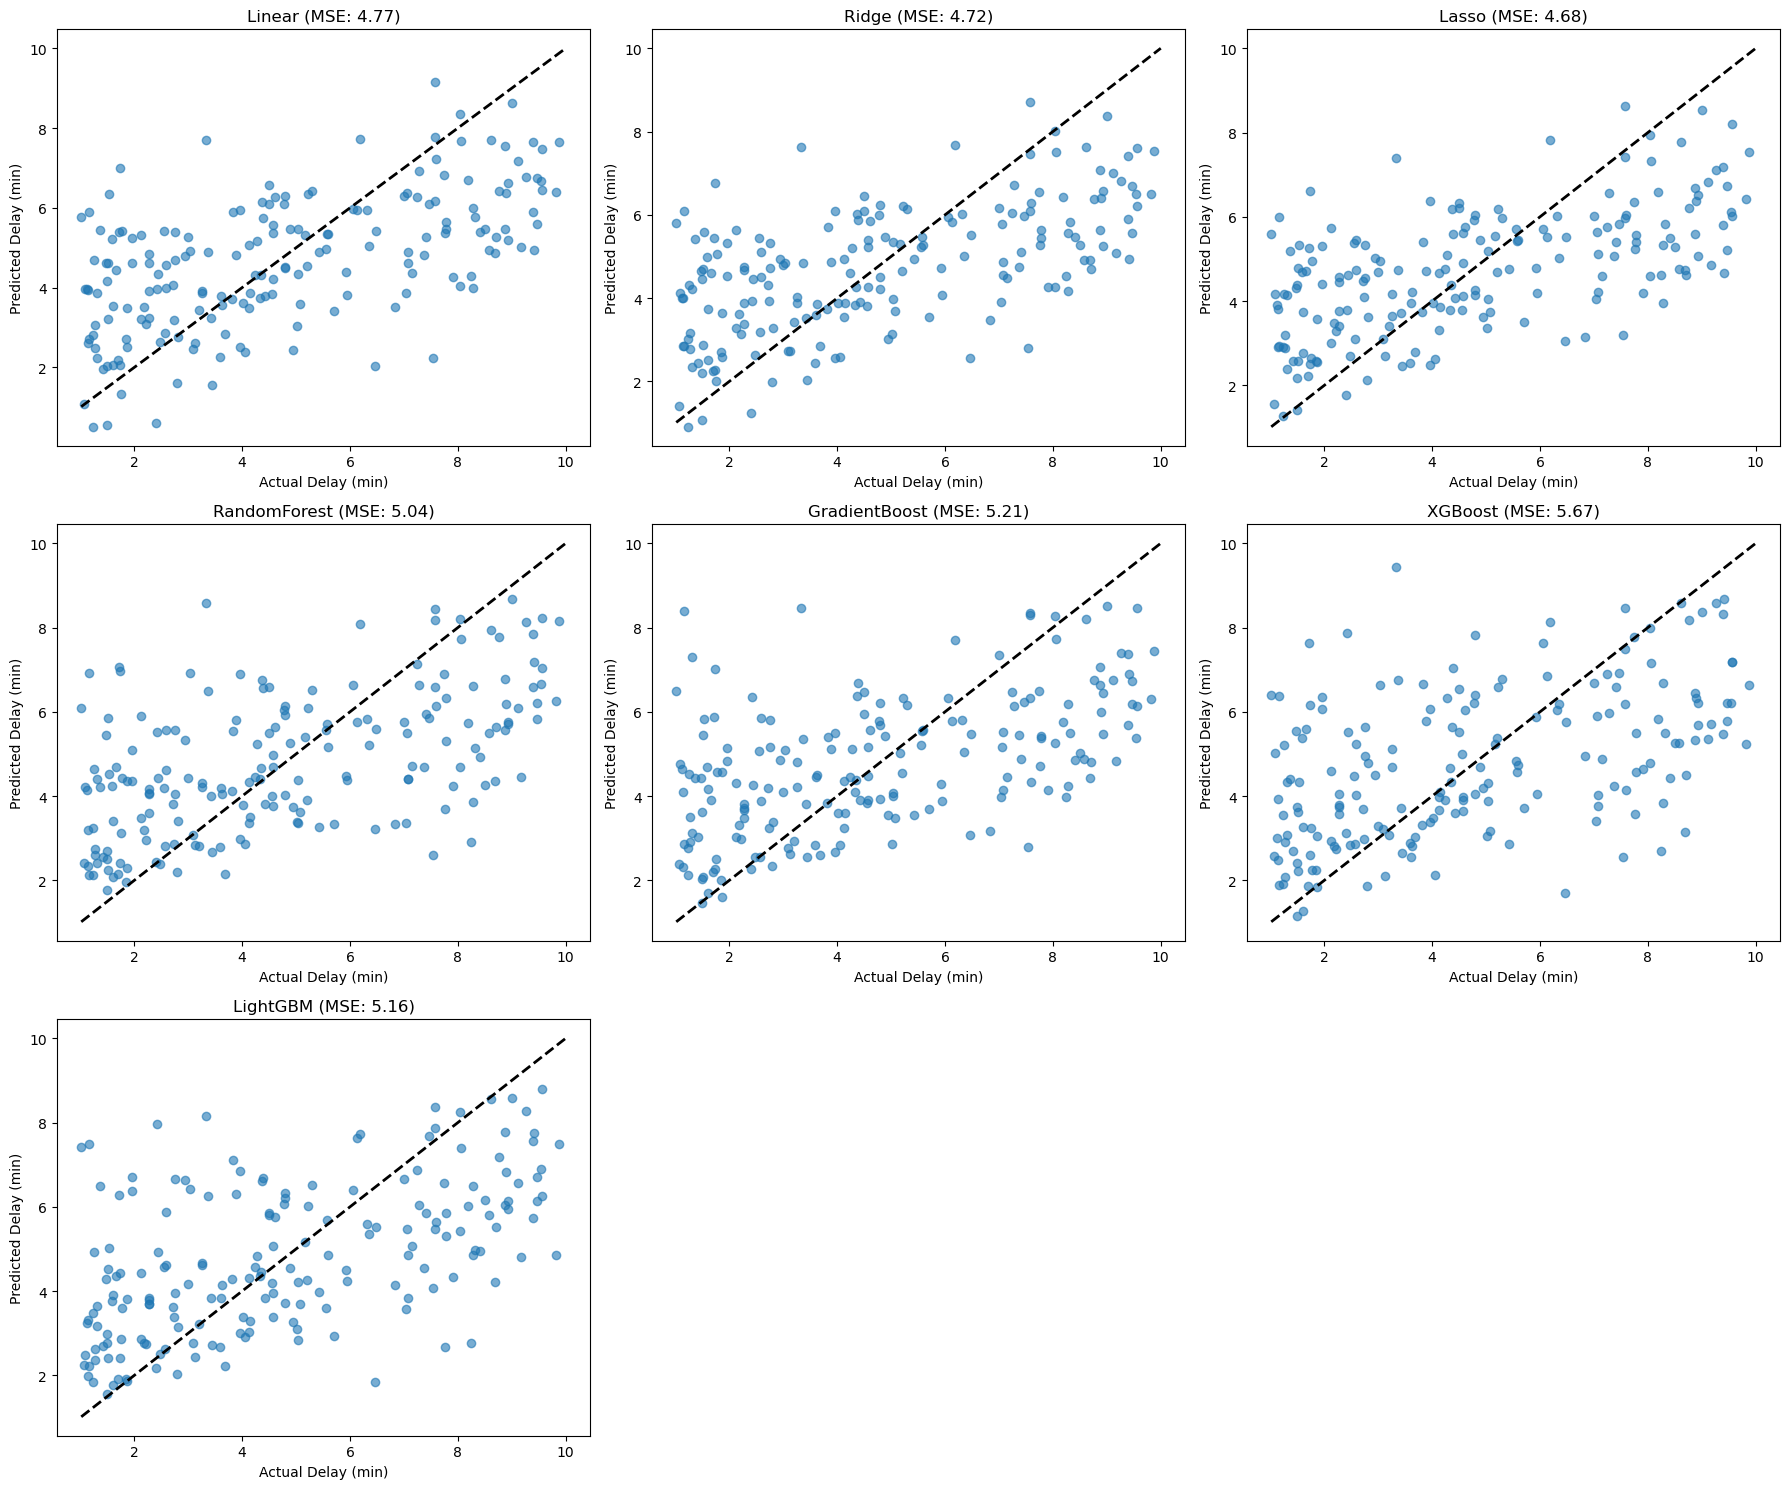

In [821]:
df["hourly_error_std"] = (
    df.groupby("hour")["error_min"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0.0))
)# remove hourly_error_trend and hourly_error_std if they are not useful
features.append("hourly_error_std")

# m

train(features=features, scale_linear_models=True)


In [822]:
df["prev_scheduled_gap"] = df.groupby("direction")["scheduled_arr"].diff().dt.total_seconds() / 60
#make sure to fill NaN values
df["prev_scheduled_gap"].fillna(0, inplace=True)

[]
Linear MSE: 4.77
Ridge MSE: 4.73
Lasso MSE: 4.69
RandomForest MSE: 4.94
GradientBoost MSE: 5.37
XGBoost MSE: 5.80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 22
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.12

RandomForest Feature Importances:
 hourly_error_trend     0.462661
hourly_error_std       0.139108
minutes_seen_before    0.073867
next_sched_gap         0.046553
opp_mean_diff          0.043190
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.567907
hourly_error_std       0.118687
minutes_seen_before    0.083774
opp_mean_diff          0.049730
next_sched_gap         0.034202
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.292899
weekday_rush           0.135771
hourly

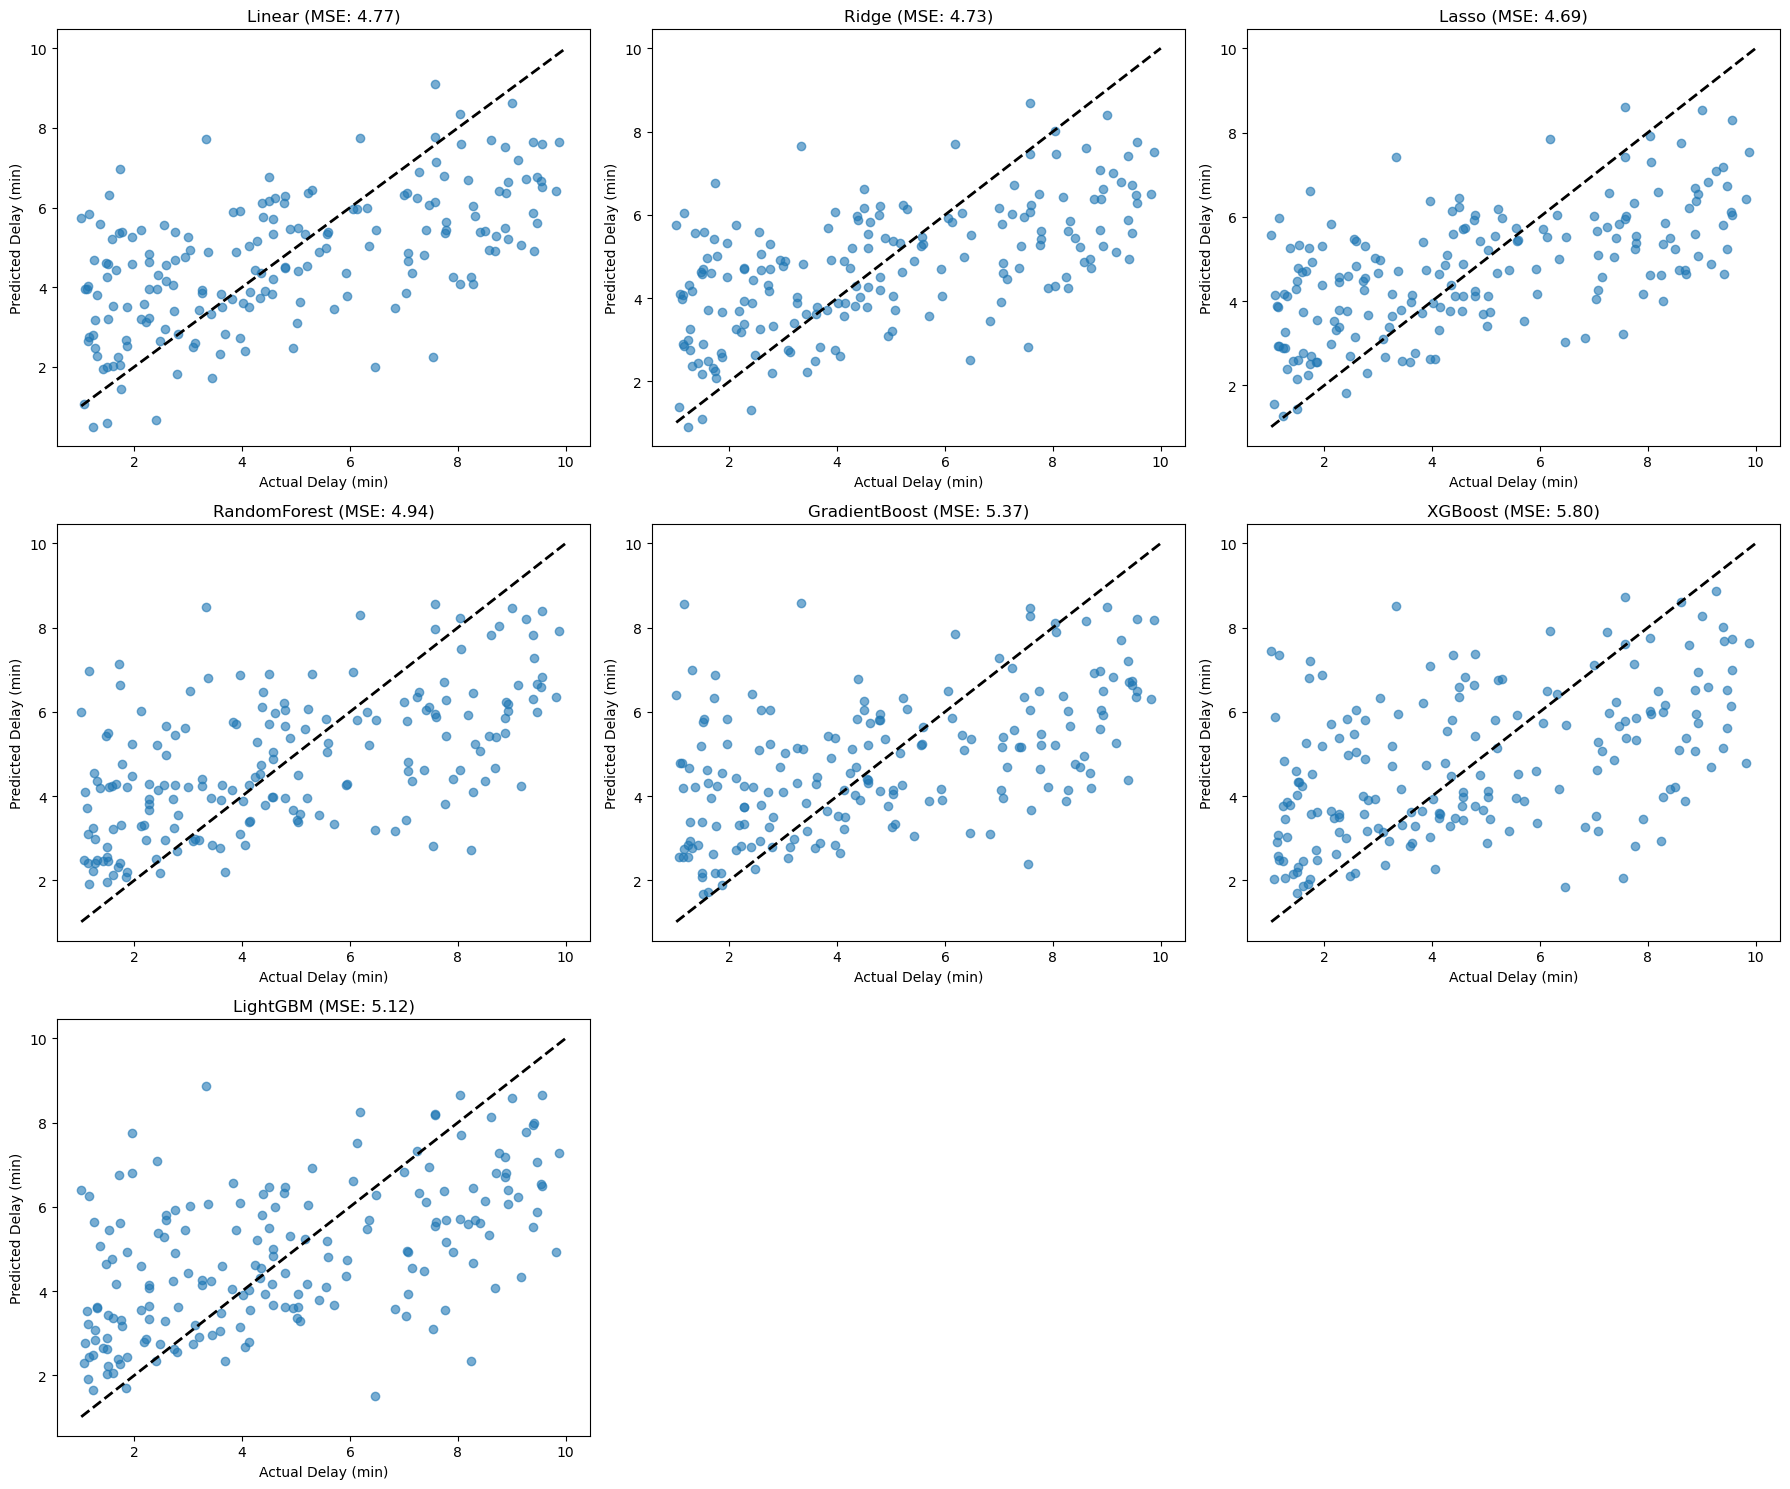

In [823]:
features.append("prev_scheduled_gap")
train(features=features, scale_linear_models=True)

In [824]:
df["is_peak_morning"] = df["hour"].between(7, 9).astype(int)
df["is_peak_evening"] = df["hour"].between(16, 18).astype(int)


In [825]:
features.append("is_peak_morning")
features.append("is_peak_evening")

[]
Linear MSE: 4.77
Ridge MSE: 4.73
Lasso MSE: 4.69
RandomForest MSE: 4.91
GradientBoost MSE: 5.36
XGBoost MSE: 5.77
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 24
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.18

RandomForest Feature Importances:
 hourly_error_trend     0.462207
hourly_error_std       0.140017
minutes_seen_before    0.072944
next_sched_gap         0.047075
opp_mean_diff          0.043086
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.568050
hourly_error_std       0.118656
minutes_seen_before    0.084347
opp_mean_diff          0.048817
next_sched_gap         0.033844
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.287161
weekday_rush           0.167605
hourly

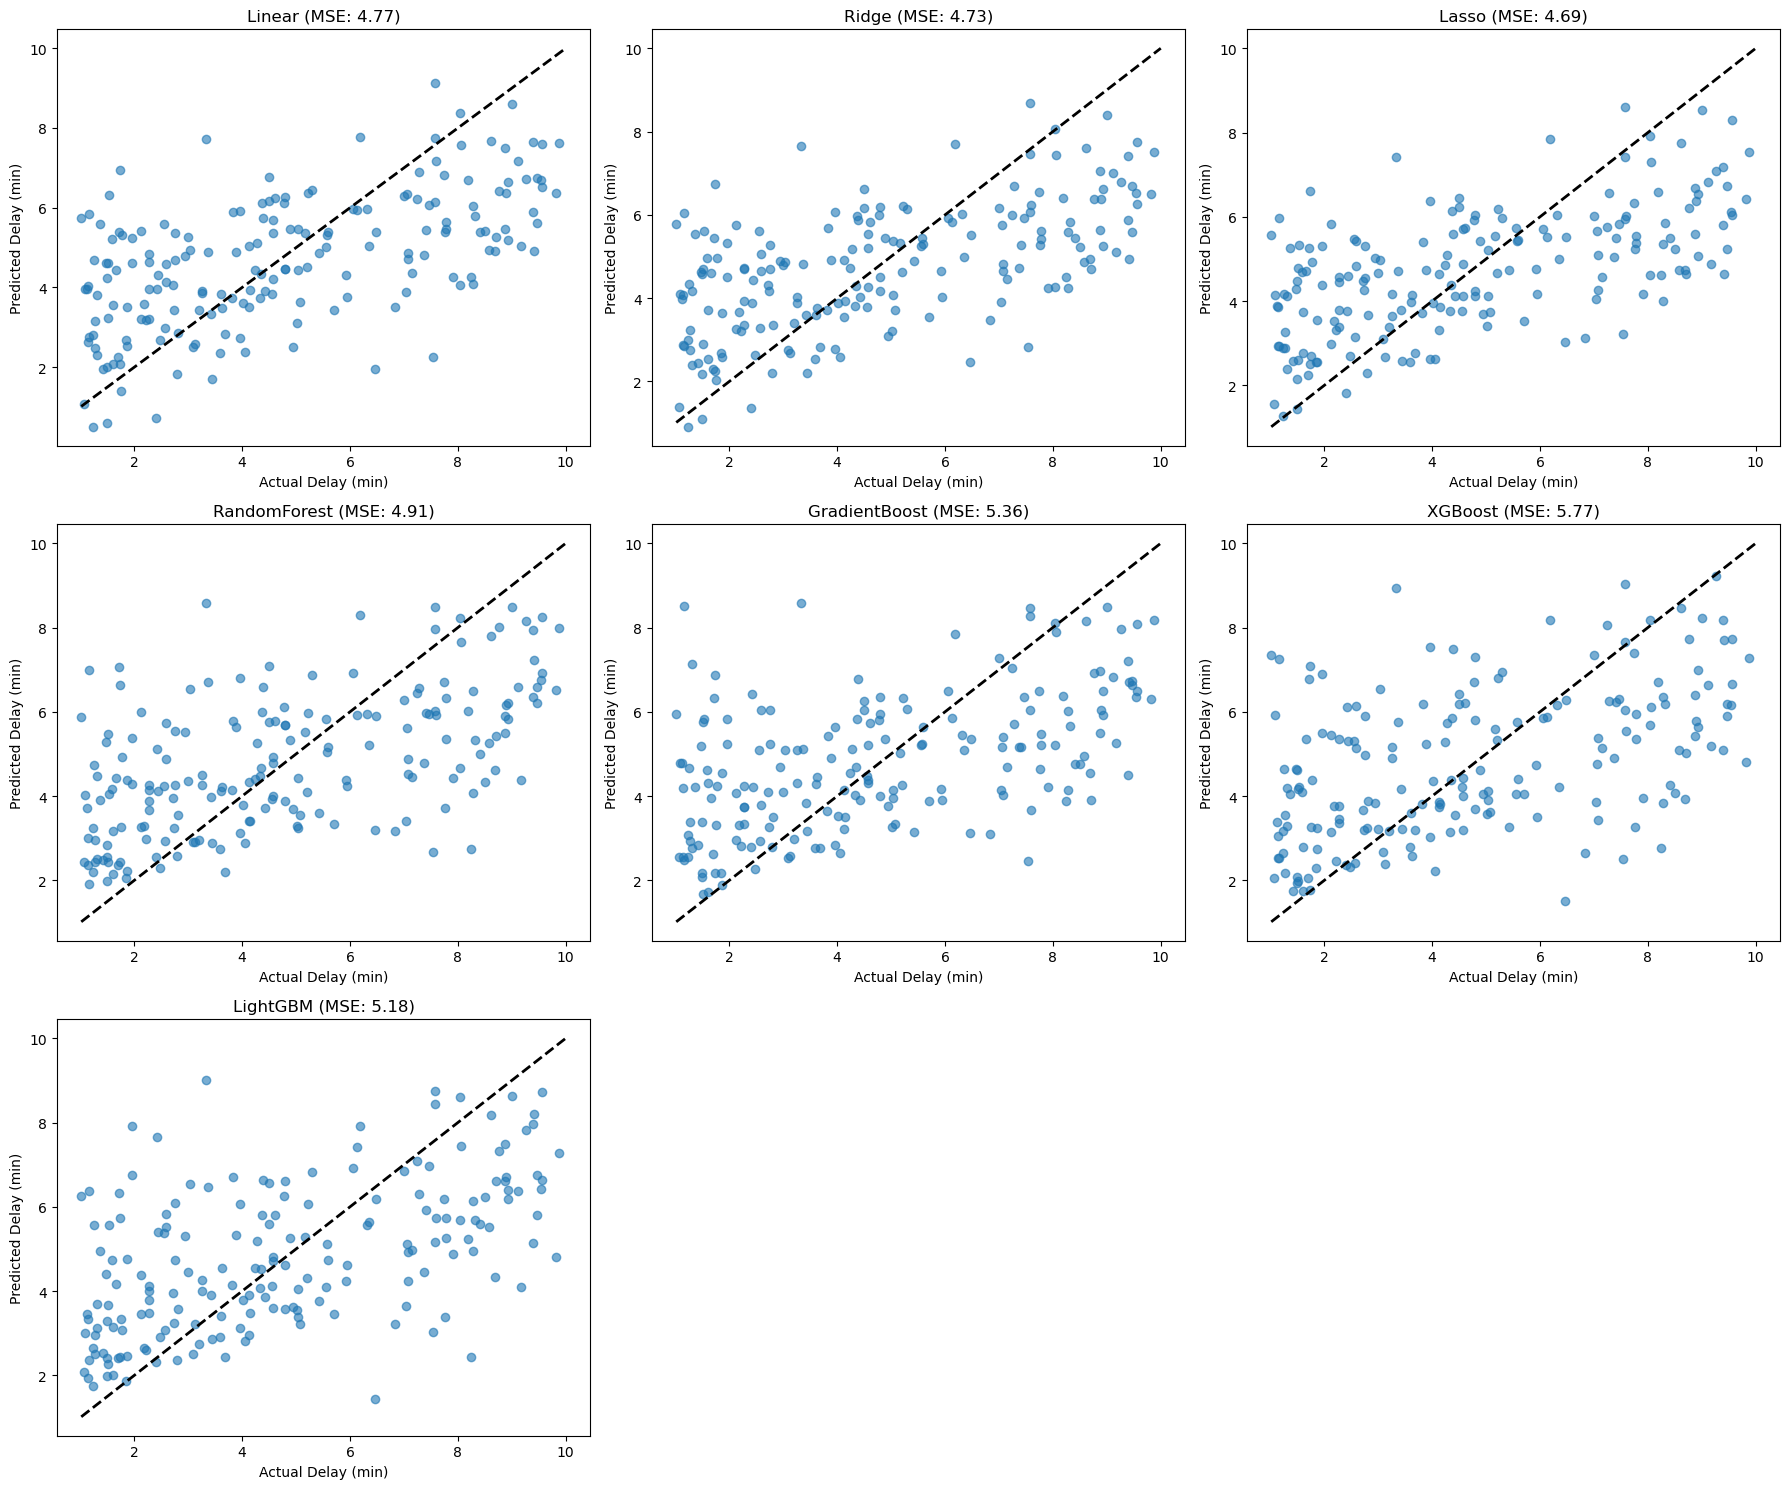

In [826]:
train(features=features, scale_linear_models=True)

In [827]:
df["error_trend_linden"] = df[df["direction_Linden"] == 1].groupby("hour")["error_min"].transform("mean")
df["error_trend_howard"] = df[df["direction_Linden"] == 0].groupby("hour")["error_min"].transform("mean")

# make sure no NaN values
df["error_trend_linden"].fillna(0, inplace=True)
df["error_trend_howard"].fillna(0, inplace=True)

In [828]:
features.append("error_trend_linden")
features.append("error_trend_howard")

In [829]:
df["dir_error_trend"] = df.apply(lambda r: r["error_trend_linden"] if r["direction_Linden"] else r["error_trend_howard"], axis=1)

# make sure no NaN values
df["dir_error_trend"].fillna(0, inplace=True)

In [830]:
features.append("dir_error_trend")

[]
Linear MSE: 4.67
Ridge MSE: 4.67
Lasso MSE: 4.66
RandomForest MSE: 4.90
GradientBoost MSE: 5.25
XGBoost MSE: 5.43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2706
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 27
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.25

RandomForest Feature Importances:
 hourly_error_trend     0.459349
hourly_error_std       0.137266
minutes_seen_before    0.073589
next_sched_gap         0.045454
opp_mean_diff          0.041208
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.567613
hourly_error_std       0.112625
minutes_seen_before    0.084754
opp_mean_diff          0.046317
next_sched_gap         0.039710
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.262067
weekday_rush           0.108363
error_

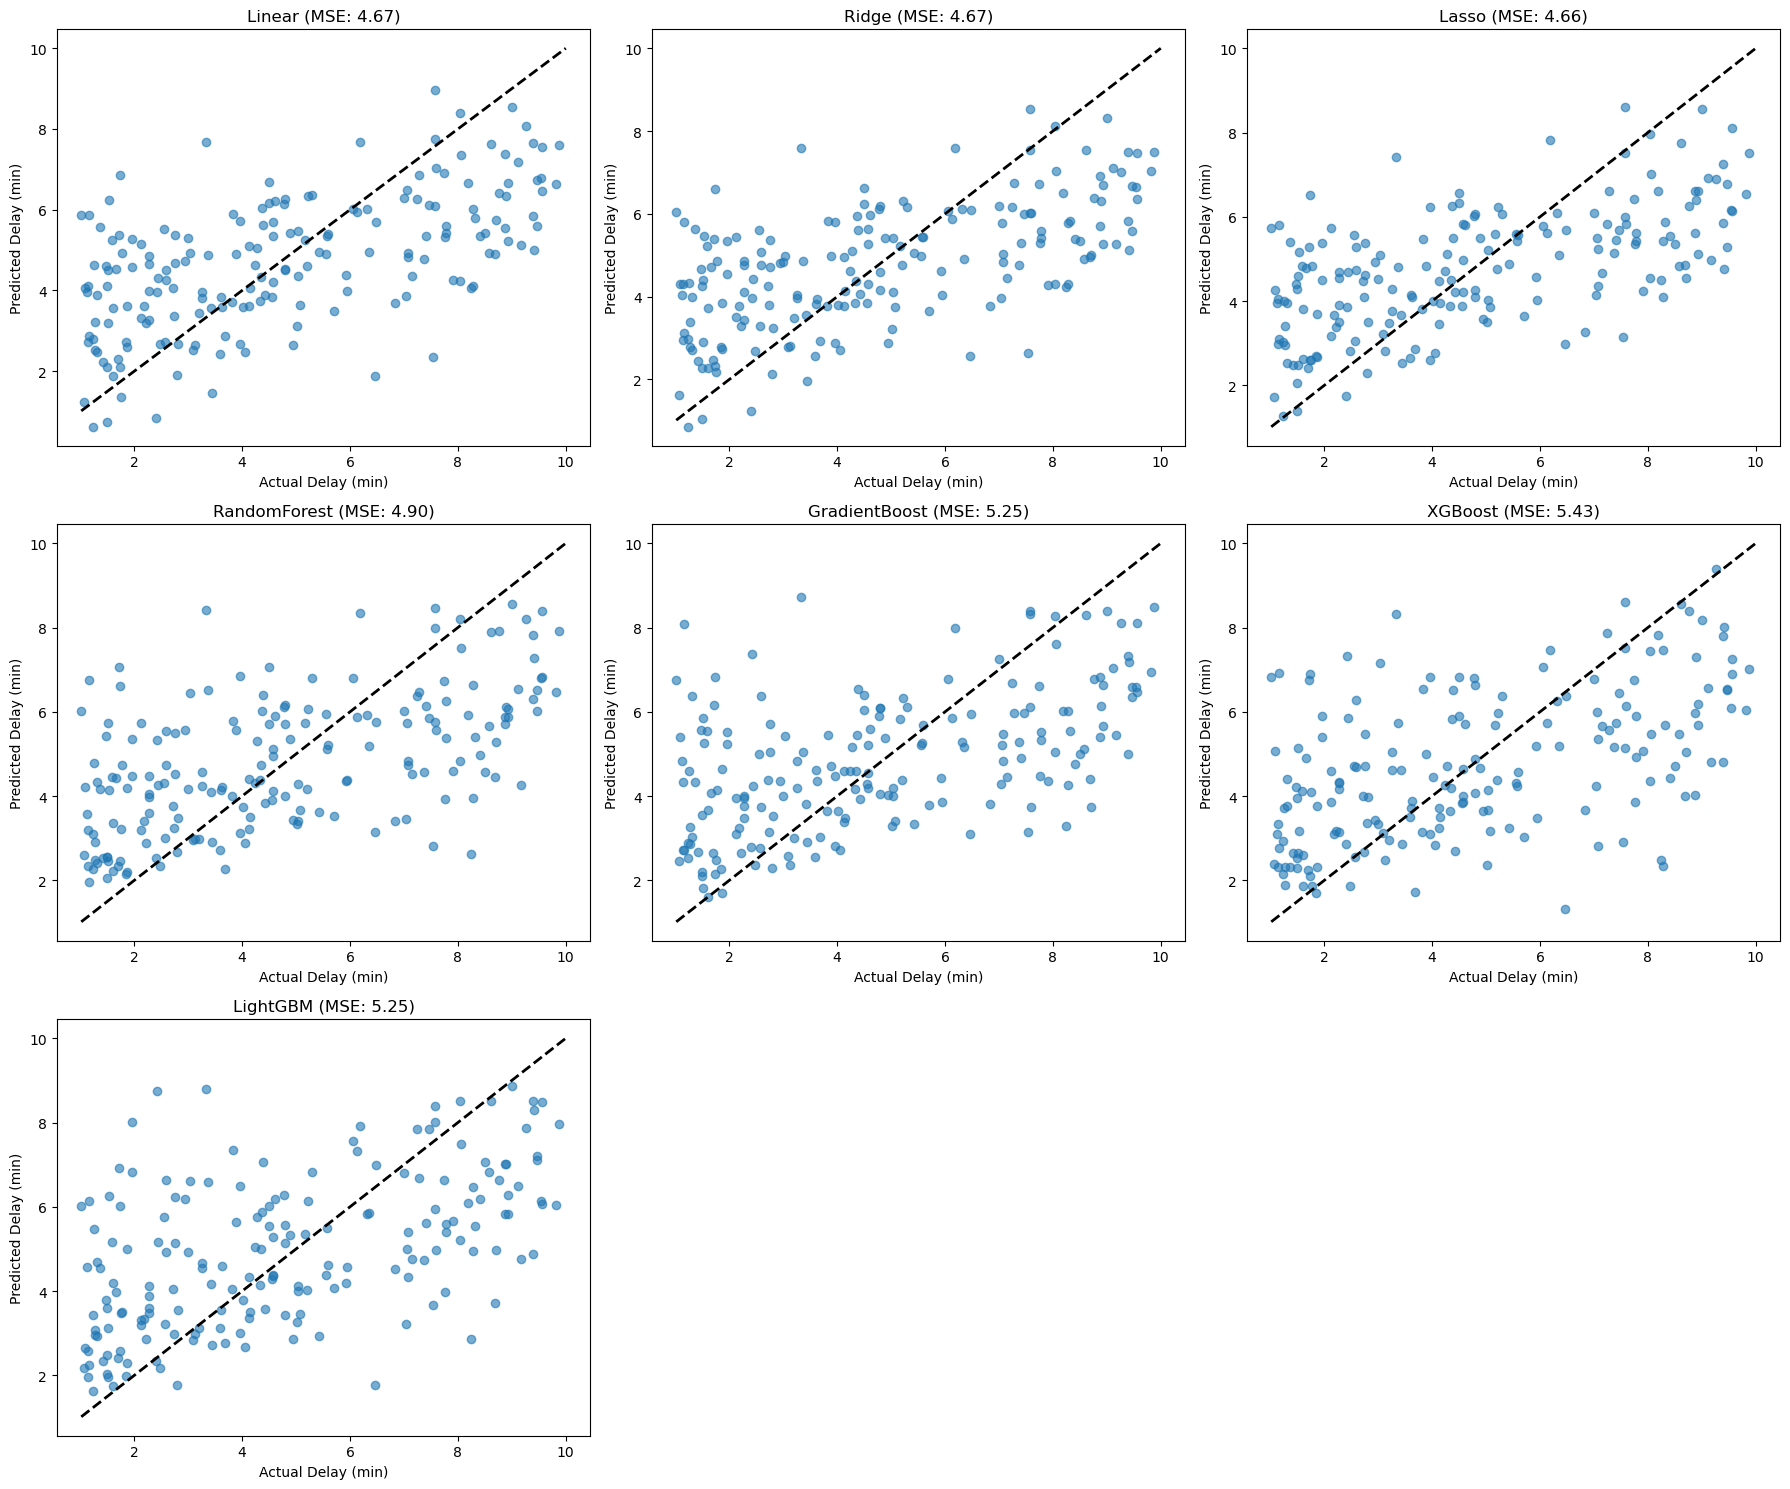

In [831]:
train(features=features, scale_linear_models=True)

In [832]:
df["hour_x_minutes_seen"] = df["hour"] * df["minutes_seen_before"]
df["opp_min_x_std"] = df["opp_min"] * df["opp_std"]
df["hour_x_direction"] = df["hour"] * df["direction_Linden"]


In [833]:
features.append("hour_x_minutes_seen")
features.append("opp_min_x_std")
features.append("hour_x_direction")

[]
Linear MSE: 4.67
Ridge MSE: 4.66
Lasso MSE: 4.64
RandomForest MSE: 4.96
GradientBoost MSE: 5.29
XGBoost MSE: 5.35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 30
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.28

RandomForest Feature Importances:
 hourly_error_trend     0.458199
hourly_error_std       0.133573
minutes_seen_before    0.068313
next_sched_gap         0.043210
opp_mean_diff          0.038208
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.560027
hourly_error_std       0.125806
minutes_seen_before    0.082702
opp_mean_diff          0.047325
next_sched_gap         0.032516
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.220538
weekday_rush           0.217175
hourly

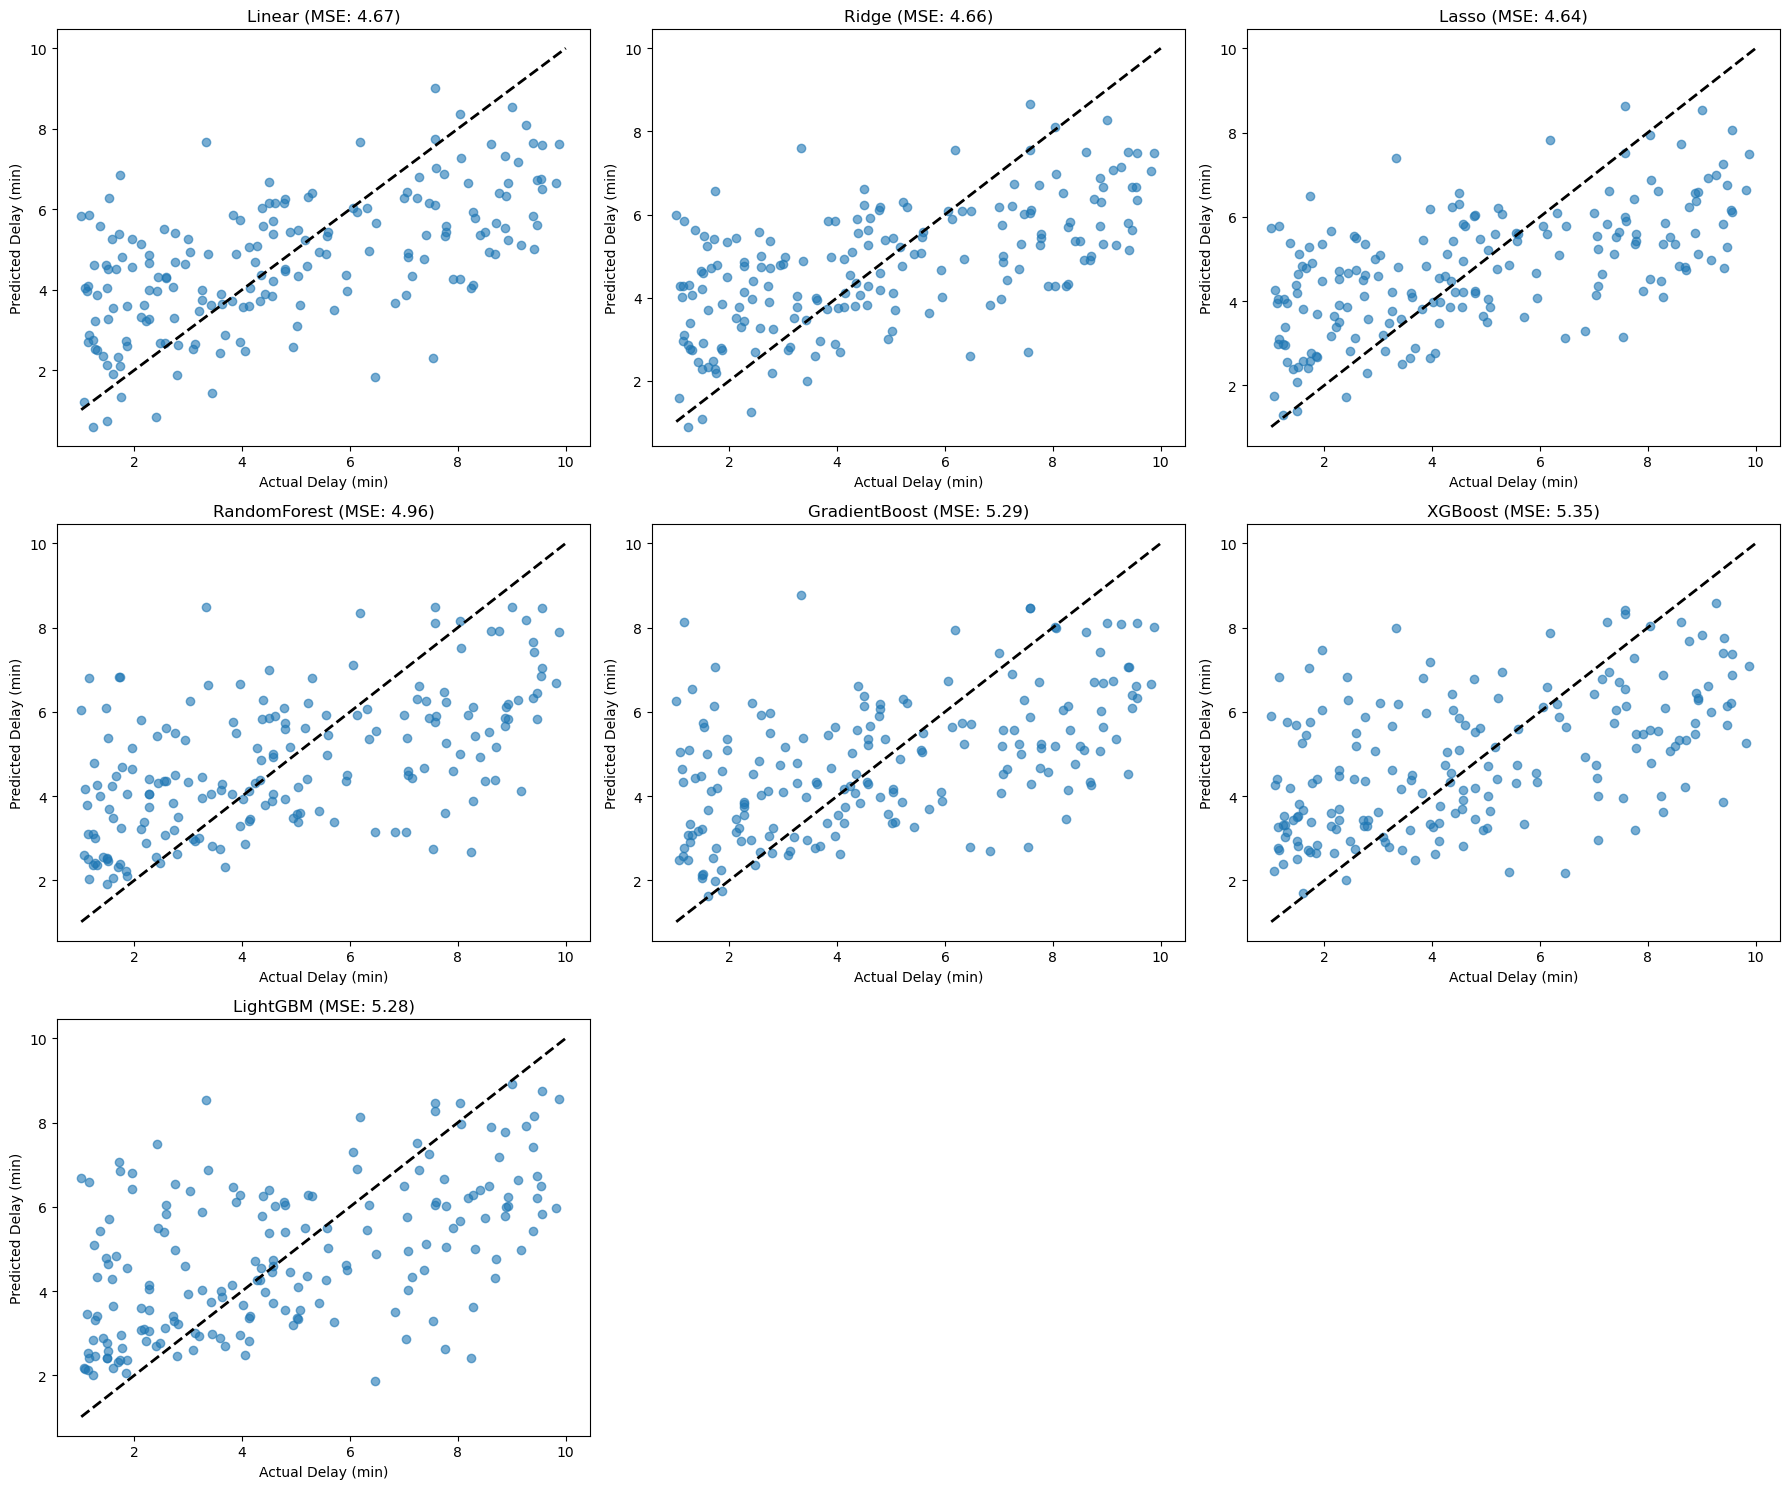

In [834]:
train(features=features, scale_linear_models=True)

In [835]:
window = "30min"
df.set_index("scheduled_arr", inplace=True)
df["trains_next_30min"] = (
    df.groupby("direction_Linden")["direction_Linden"]
        .transform(lambda x: x.rolling(window).count().shift(-1))
          .fillna(0)
)
df.reset_index(inplace=True)
features.append("trains_next_30min")


[]
Linear MSE: 4.67
Ridge MSE: 4.66
Lasso MSE: 4.64
RandomForest MSE: 4.96
GradientBoost MSE: 5.48
XGBoost MSE: 5.31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 31
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.21

RandomForest Feature Importances:
 hourly_error_trend     0.457994
hourly_error_std       0.132890
minutes_seen_before    0.068522
next_sched_gap         0.042542
opp_mean_diff          0.038598
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.561375
hourly_error_std       0.117059
minutes_seen_before    0.077270
opp_mean_diff          0.047302
next_sched_gap         0.029277
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.229729
weekday_rush           0.173246
hourly

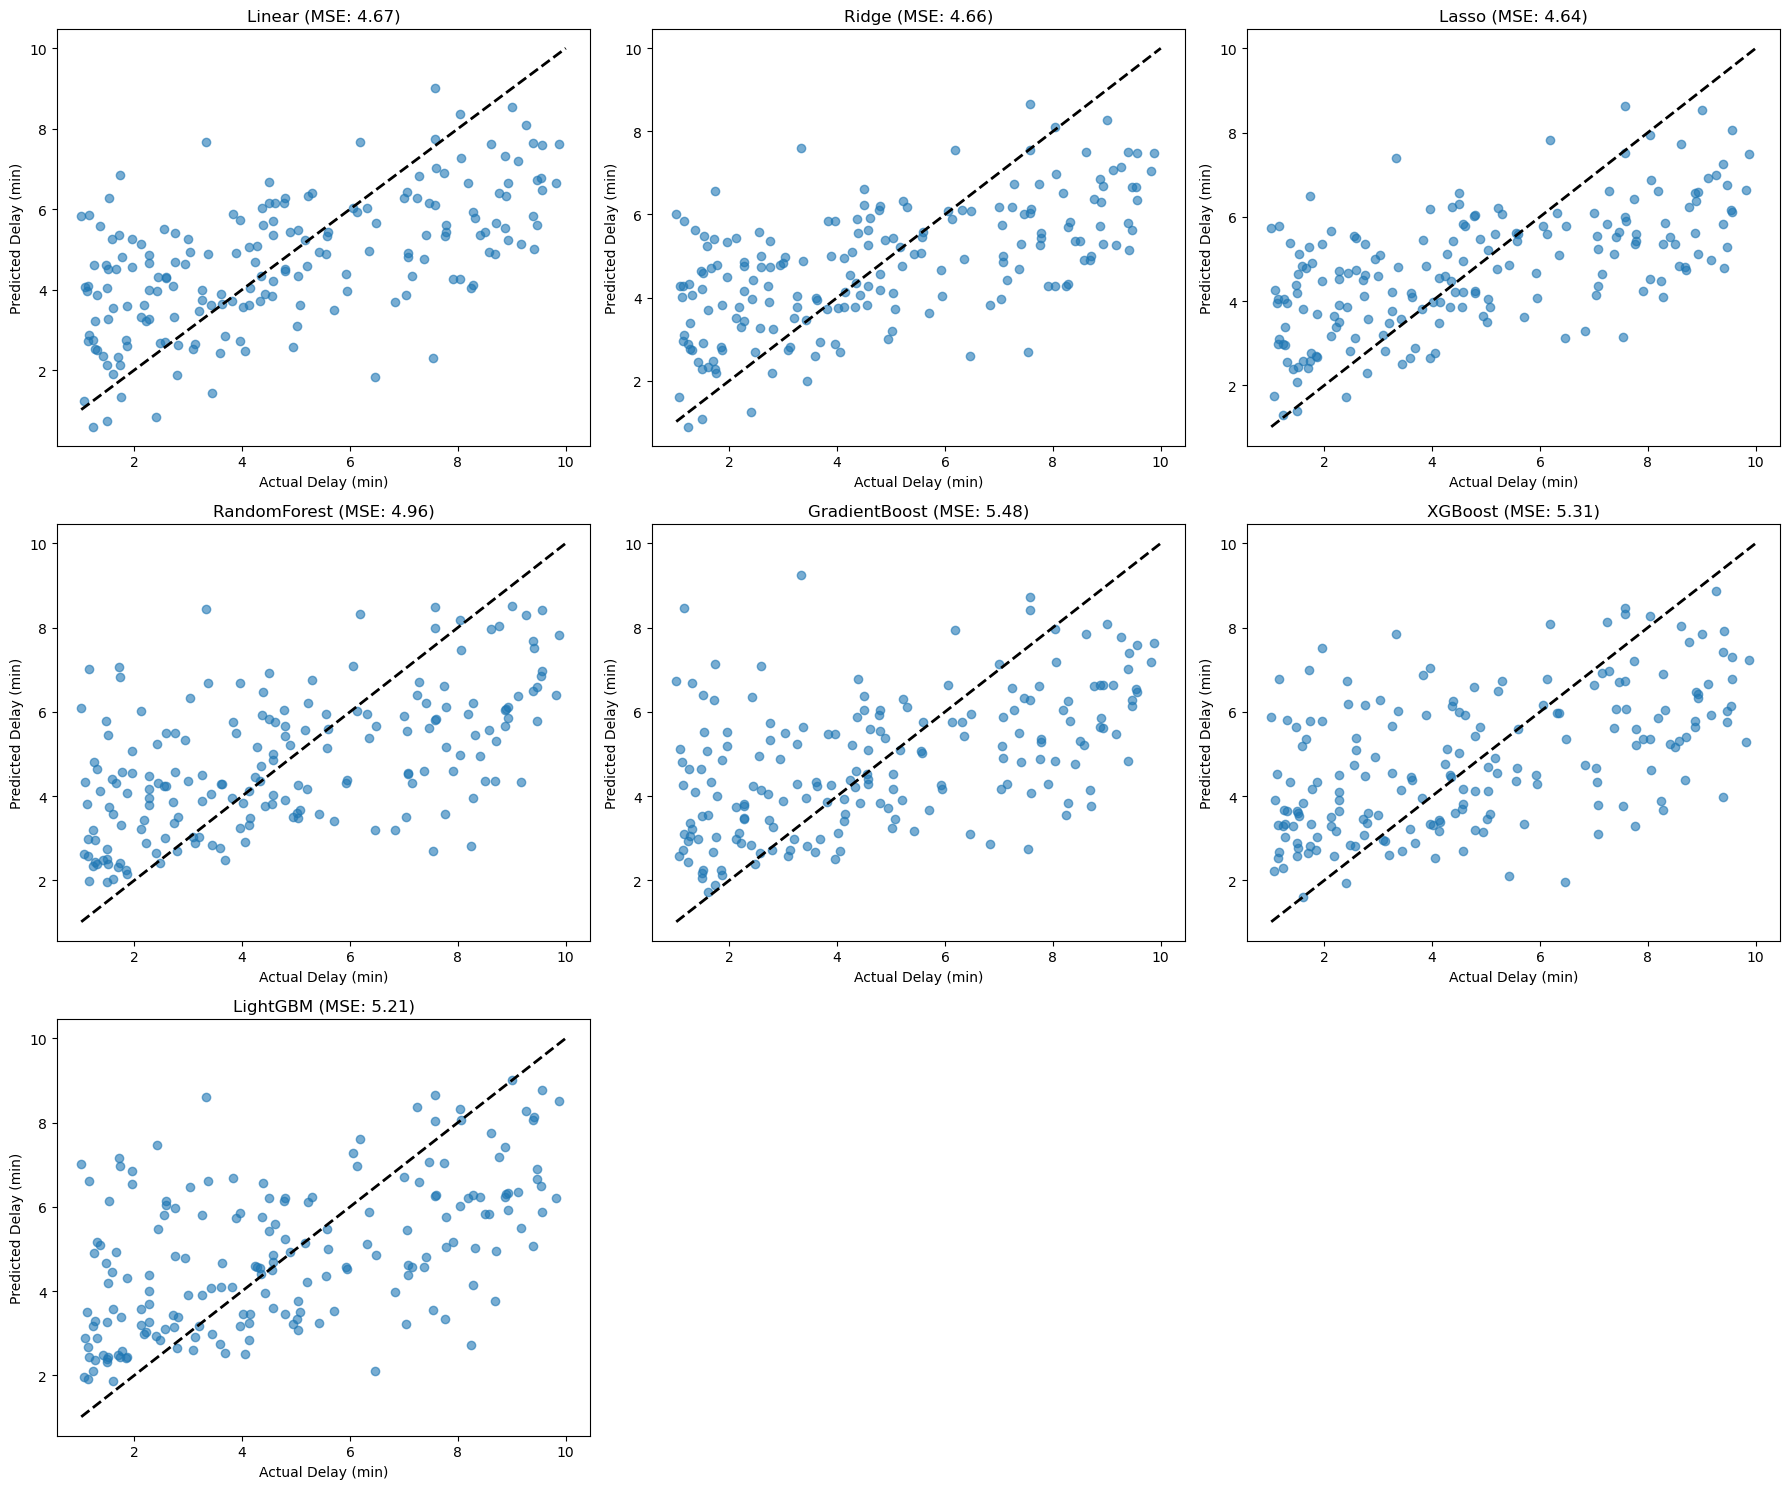

In [836]:
train(features=features, scale_linear_models=True)

In [837]:
df["prev_error_min"]   = df.groupby("direction_Linden")["error_min"].shift(1).fillna(0)
df["prev_error_min_2"] = df.groupby("direction_Linden")["error_min"].shift(2).fillna(0)
df["error_diff_1_2"]   = (df["prev_error_min"] - df["prev_error_min_2"]).fillna(0)


In [838]:
features.append("prev_error_min")
features.append("prev_error_min_2")
features.append("error_diff_1_2")

In [842]:
# remove any dupes from features
features = list(set(features))

[]
Linear MSE: 4.69
Ridge MSE: 4.68
Lasso MSE: 4.64
RandomForest MSE: 5.02
GradientBoost MSE: 5.02
XGBoost MSE: 5.66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 33
[LightGBM] [Info] Start training from score 5.237772
LightGBM MSE: 5.54

RandomForest Feature Importances:
 hourly_error_trend     0.453219
hourly_error_std       0.126665
minutes_seen_before    0.066029
next_sched_gap         0.037926
opp_mean_diff          0.035897
dtype: float64

GradientBoost Feature Importances:
 hourly_error_trend     0.563804
hourly_error_std       0.119600
minutes_seen_before    0.076920
opp_mean_diff          0.040632
next_sched_gap         0.024987
dtype: float64

XGBoost Feature Importances:
 hourly_error_trend     0.251623
weekday_rush           0.122298
minute

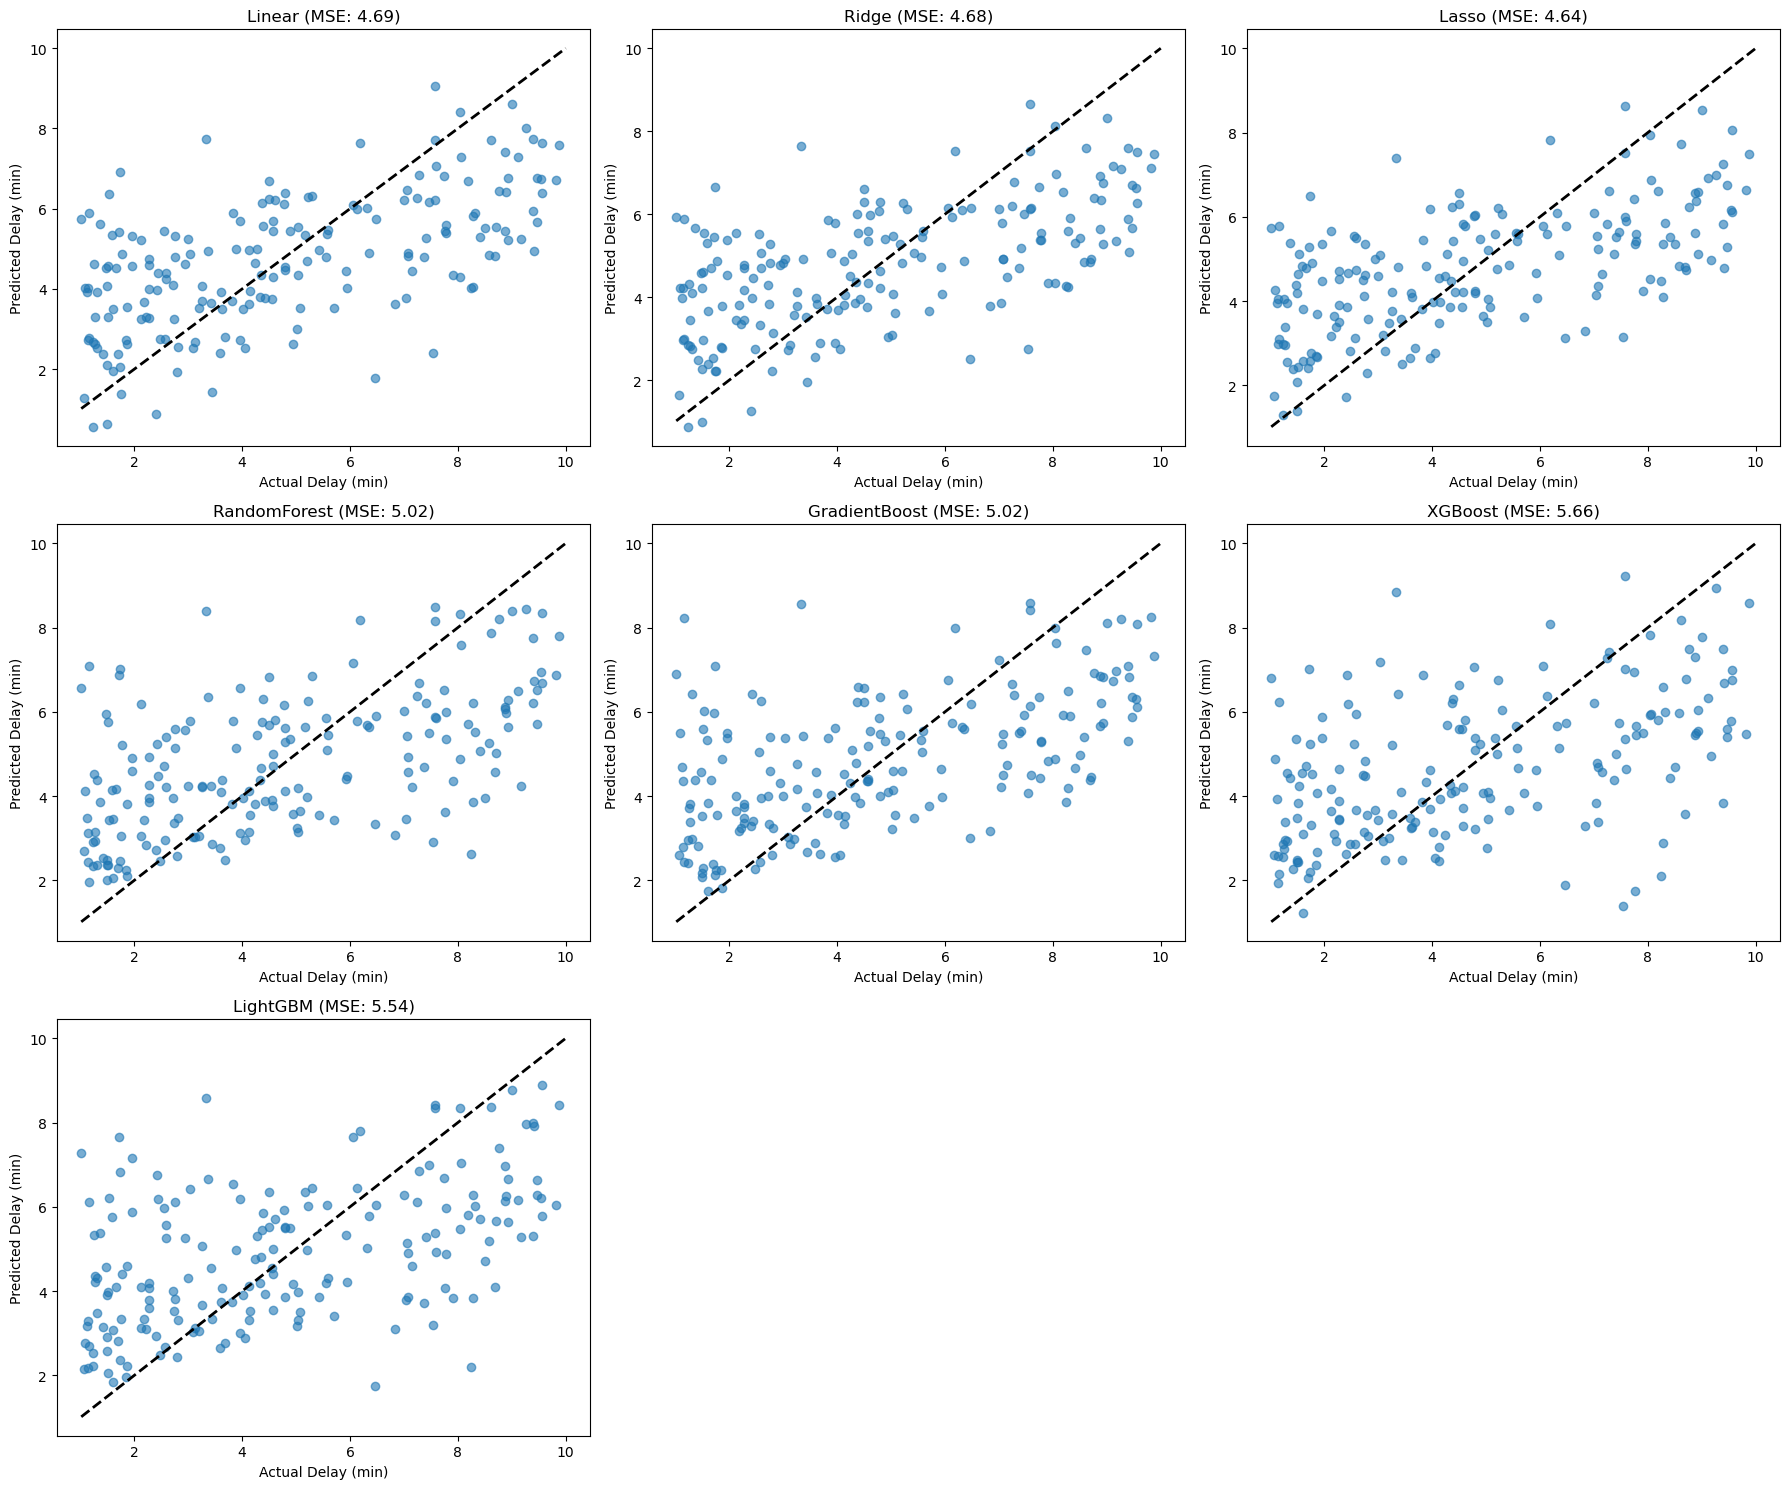

In [843]:
train(features=features, scale_linear_models=True)